# REFMAP laboratory listening test 1 analysis: Rough confirmatory data analysis

## Setup

In [1]:
# import packages
import sys
import os
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import dabest
import warnings

# Suppress FutureWarning messages to quiet pandas
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# set plot parameters
sns.set_style('white')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 9
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]

np.random.seed(303)

# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True

# check/open QApplication instance
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance() 


Set the saveplots toggle to True if plot saving is desired:

In [3]:
saveplots = True

if saveplots:
    # select figure output save path
    outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots")

    # create subfolders if not already existing
    try:
        os.mkdir(os.path.join(outFigPath, "svg"))
    except FileExistsError:
        pass

    try:
        os.mkdir(os.path.join(outFigPath, "pdf"))
    except FileExistsError:
        pass


## Import data and organise

In [48]:
# import test data
fileExts = "*.csv"

# Part A
dataBySubjAFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataA_BySubj.csv",
                                                       caption=r"Open refmap_listest1_testdataA_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataBySubjTestA = pd.read_csv(dataBySubjAFilePath, index_col=0)

# Part B
dataBySubjBFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataB_BySubj.csv",
                                                       caption=r"Open refmap_listest1_testdataB_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataBySubjTestB = pd.read_csv(dataBySubjBFilePath, index_col=0)

# Both parts
dataBySubjFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdata_BySubj.csv",
                                                       caption=r"Open refmap_listest1_testdata_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataBySubjTest = pd.read_csv(dataBySubjFilePath, index_col=0)


In [5]:
# categorise columns

for dataset in [dataBySubjTestA, dataBySubjTest]:
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ["Park", "Street"])
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["No UAS", "-16", "-10", "-4", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["No UAS", "42", "48", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["No UAS", "Flyby", "Landing", "Takeoff"])
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["No UAS", "H520", "M300", "T150"])

for dataset in [dataBySubjTestB]:
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ["Park", "Street"])
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["No UAS", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["No UAS", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["No UAS", "Flyby"])
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["No UAS", "H520", "T150"])


## Setup output dataframes

In [6]:
out = pd.DataFrame()
outd = pd.DataFrame()

savedata = False

if savedata:
    # select data output save path
    outDataPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save output data")


## Part A

### Scaled vs modelled UAS LAeq level 2 

In [7]:
# select subset of data for analysis and sort
data = dataBySubjTestA[dataBySubjTestA['Recording'].str.contains("_F_2")]
data = data.loc[:, ['ID#', 'StimFile', 'AmbientEnv', 'Annoyance']]
data.sort_values(by=['ID#', 'StimFile'], inplace=True)

# add column to indicate modelled or scaled, and create a dummy pairing ID
data['LvlType'] = "Modelled"
data.loc[data['StimFile'].str.contains("PwrScale"), 'LvlType'] = "Scaled"
data['dummyID'] = np.repeat(np.arange(1, len(data['ID#'])//len(data['LvlType'].unique()) + 1, dtype=int), len(data['LvlType'].unique()), axis=0)



In [8]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=("Modelled", "Scaled"), x='LvlType', y='Annoyance', paired='baseline',
                         id_col='dummyID', resamples=5000, random_seed=303)


control    test  control_N  test_N      effect_size is_paired  difference  \
0  Modelled  Scaled        246     246  mean difference  baseline    0.056911   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95 -0.195122  0.317073            0.647471          0.69952   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              7362.0                  0.662346                    -0.437207

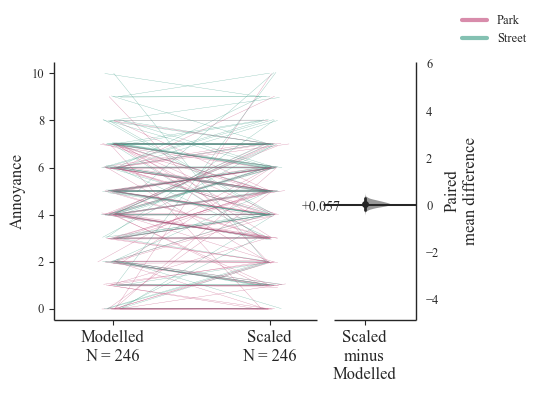

In [9]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 4))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='AmbientEnv',
                                   contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                   slopegraph_xjitter=0.03, slopegraph_yjitter=0.02, jitter_seed=303,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette=mycolours[1:3], es_marker_size=4, contrast_ylim=(-5.5, 4.5),
                                   legend_kwargs={'loc': 'lower center'}, ax=ax)
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtALvlScaleDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtALvlScaleDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])
dataMD;
dataloadBL.mean_diff.statistical_tests


In [10]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control    test  control_N  test_N effect_size is_paired  difference  ci  \
0  Modelled  Scaled        246     246   Cohen's d  baseline      0.0239  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0 -0.079853  0.134437            0.647471          0.69952   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              7362.0                  0.662346                    -0.437207

### UAS LAeq segregated by ambient environment

In [11]:
# select subset of data for analysis and sort
data = dataBySubjTestA[~dataBySubjTestA['Recording'].str.contains("PwrScale")]
data = data[data['UASLAeq'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'AmbientEnv', 'UASLAeq', 'UASType', 'UASOperation', 'Annoyance']]
data.sort_values(by=['ID#', 'AmbientEnv', 'UASOperation', 'UASType', 'UASLAeq'], inplace=True)

dataPk = data.loc[data['AmbientEnv'] == "Park", :]
dataSt = data.loc[data['AmbientEnv'] == "Street", :]

# create a dummy pairing ID
dataPk['dummyID'] = np.repeat(np.arange(1, len(dataPk['ID#'])//len(dataPk['UASLAeq'].unique()) + 1, dtype=int), len(dataPk['UASLAeq'].unique()), axis=0)
dataSt['dummyID'] = np.repeat(np.arange(1, len(dataSt['ID#'])//len(dataSt['UASLAeq'].unique()) + 1, dtype=int), len(dataSt['UASLAeq'].unique()), axis=0)


In [12]:
# assign data for processing
dataPkloadSQ = dabest.load(data=dataPk, idx=("42", "48", "54", "60"), x='UASLAeq', y='Annoyance', paired='sequential',
                           id_col='dummyID', resamples=5000, random_seed=303)
dataStloadSQ = dabest.load(data=dataSt, idx=("42", "48", "54", "60"), x='UASLAeq', y='Annoyance', paired='sequential',
                           id_col='dummyID', resamples=5000, random_seed=808)

control test  control_N  test_N      effect_size   is_paired  difference  \
0      42   48        369     369  mean difference  sequential    0.951220   
1      48   54        369     369  mean difference  sequential    0.861789   
2      54   60        369     369  mean difference  sequential    0.978320   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.728997  1.176152              0.0002     1.012021e-15   
1  95  0.620596  1.089431              0.0002     2.516079e-13   
2  95  0.731707  1.222222              0.0002     1.623886e-12   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              8576.0              2.420381e-15                    -8.273149  
1             10578.5              5.236929e-12                    -7.133314  
2             10817.5              1.563889e-13                    -7.669002

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


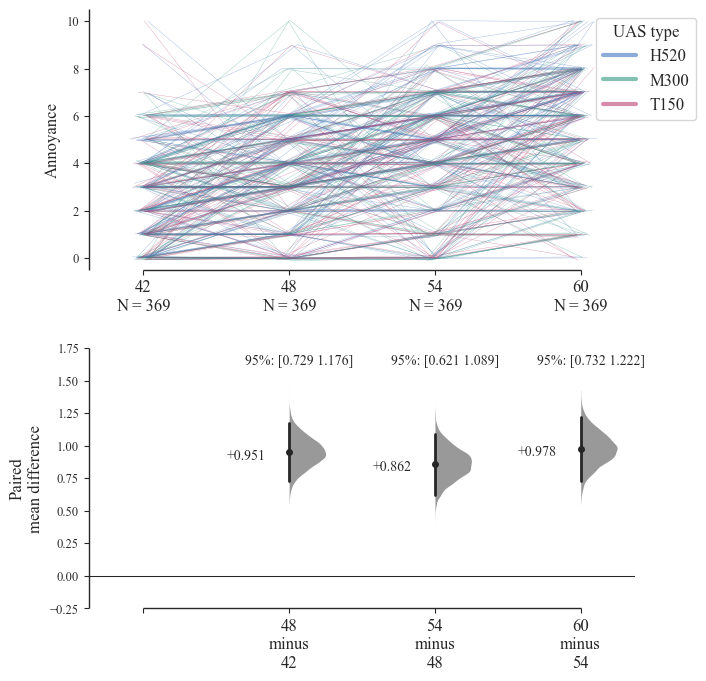

In [13]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataPkMD = dataPkloadSQ.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASType',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.03, slopegraph_yjitter=0.03, jitter_seed=303,
                                       custom_palette=mycolours, es_marker_size=4, contrast_ylim=(-0.25, 1.75), float_contrast=True,
                                       contrast_show_es=True, es_sf=3,
                                       legend_kwargs={'loc': 'upper center', 'title': r"UAS type", 'fontsize': 12,
                                                      'frameon': True, 'title_fontsize': 12}, ax=ax)
diffs = np.round(dataPkloadSQ.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-3.4, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtALAeqParkDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtALAeqParkDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataPkloadSQ.mean_diff.statistical_tests])

dataPkMD;
dataPkloadSQ.mean_diff.statistical_tests


In [14]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataPkloadSQ.cohens_d.statistical_tests])
dataPkloadSQ.cohens_d.statistical_tests


control test  control_N  test_N effect_size   is_paired  difference  ci  \
0      42   48        369     369   Cohen's d  sequential    0.455334  95   
1      48   54        369     369   Cohen's d  sequential    0.375490  95   
2      54   60        369     369   Cohen's d  sequential    0.401178  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.344373  0.568954              0.0002     1.012021e-15   
1  0.267149  0.482397              0.0002     2.516079e-13   
2  0.301119  0.502650              0.0002     1.623886e-12   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              8576.0              2.420381e-15                    -8.273149  
1             10578.5              5.236929e-12                    -7.133314  
2             10817.5              1.563889e-13                    -7.669002

control test  control_N  test_N      effect_size   is_paired  difference  \
0      42   48        369     369  mean difference  sequential    0.371274   
1      48   54        369     369  mean difference  sequential    0.384824   
2      54   60        369     369  mean difference  sequential    0.959350   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.159892  0.577236              0.0004     6.386729e-04   
1  95  0.162602  0.607046              0.0008     1.502871e-04   
2  95  0.734417  1.197832              0.0002     6.468262e-16   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             12043.5              6.801265e-04                    -3.426642  
1             13070.0              6.531619e-04                    -3.437966  
2              9045.5              4.711984e-15                    -8.178623

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


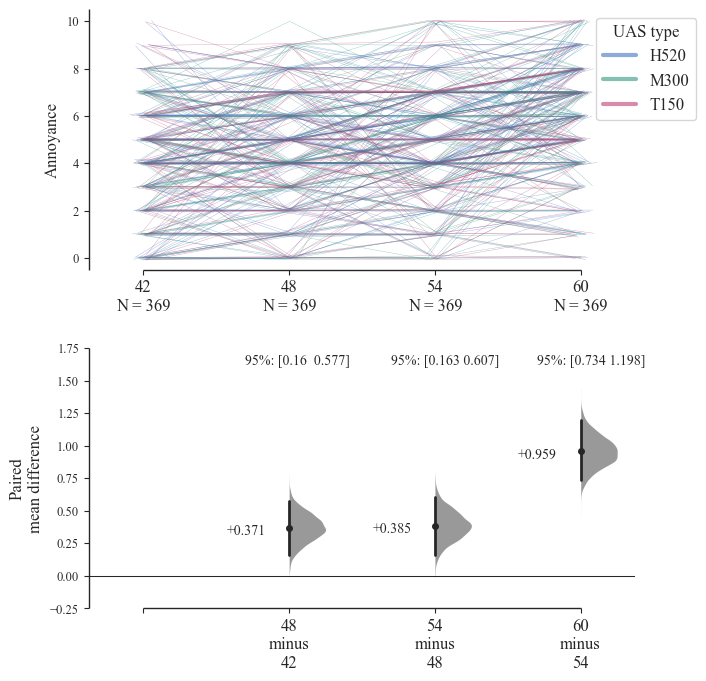

In [15]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataStMD = dataStloadSQ.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASType',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.03, slopegraph_yjitter=0.03, jitter_seed=303,
                                       custom_palette=mycolours, es_marker_size=4, contrast_ylim=(-0.25, 1.75), float_contrast=True,
                                       contrast_show_es=True, es_sf=3,
                                       legend_kwargs={'loc': 'upper center', 'title': r"UAS type", 'fontsize': 12,
                                                      'frameon': True, 'title_fontsize': 12}, ax=ax)
diffs = np.round(dataStloadSQ.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-3.4, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtALAeqStreetDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtALAeqStreetDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataStloadSQ.mean_diff.statistical_tests])

dataStMD;
dataStloadSQ.mean_diff.statistical_tests


In [16]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataStloadSQ.cohens_d.statistical_tests])
dataStloadSQ.cohens_d.statistical_tests


control test  control_N  test_N effect_size   is_paired  difference  ci  \
0      42   48        369     369   Cohen's d  sequential    0.155188  95   
1      48   54        369     369   Cohen's d  sequential    0.162379  95   
2      54   60        369     369   Cohen's d  sequential    0.403855  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.066208  0.243645              0.0004     6.386729e-04   
1  0.068055  0.256107              0.0008     1.502871e-04   
2  0.306873  0.512212              0.0002     6.468262e-16   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             12043.5              6.801265e-04                    -3.426642  
1             13070.0              6.531619e-04                    -3.437966  
2              9045.5              4.711984e-15                    -8.178623

### UAS types and operations segregated by ambient environment

#### UAS type

In [17]:
# select subset of data for analysis and sort
data = dataBySubjTestA[~dataBySubjTestA['Recording'].str.contains("PwrScale")]
data = data[data['UASType'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'AmbientEnv', 'UASLAeq', 'UASType', 'UASOperation', 'Annoyance']]
data.sort_values(by=['ID#', 'UASLAeq', 'UASOperation', 'UASType', 'AmbientEnv'], inplace=True)

dataPk = data.loc[data['AmbientEnv'] == "Park", :]
dataSt = data.loc[data['AmbientEnv'] == "Street", :]

# create a dummy pairing ID
dataPk['dummyID'] = np.repeat(np.arange(1, len(dataPk['ID#'])//len(dataPk['UASType'].unique()) + 1, dtype=int), len(dataPk['UASType'].unique()), axis=0)
dataSt['dummyID'] = np.repeat(np.arange(1, len(dataSt['ID#'])//len(dataSt['UASType'].unique()) + 1, dtype=int), len(dataSt['UASType'].unique()), axis=0)


In [18]:
# assign data for processing
dataPkloadBL = dabest.load(data=dataPk, idx=("H520", "M300", "T150"), x='UASType', y='Annoyance', paired='baseline',
                           id_col='dummyID', resamples=5000, random_seed=808)
dataStloadBL = dabest.load(data=dataSt, idx=("H520", "M300", "T150"), x='UASType', y='Annoyance', paired='baseline',
                           id_col='dummyID', resamples=5000, random_seed=808)


control  test  control_N  test_N      effect_size is_paired  difference  ci  \
0    H520  M300        492     492  mean difference  baseline   -0.357724  95   
1    H520  T150        492     492  mean difference  baseline   -0.449187  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0 -0.567073 -0.152439              0.0006         0.001376   
1 -0.658537 -0.241870              0.0010         0.000021   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             23542.0                  0.000754                     3.390566  
1             27984.5                  0.000028                     4.231828

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


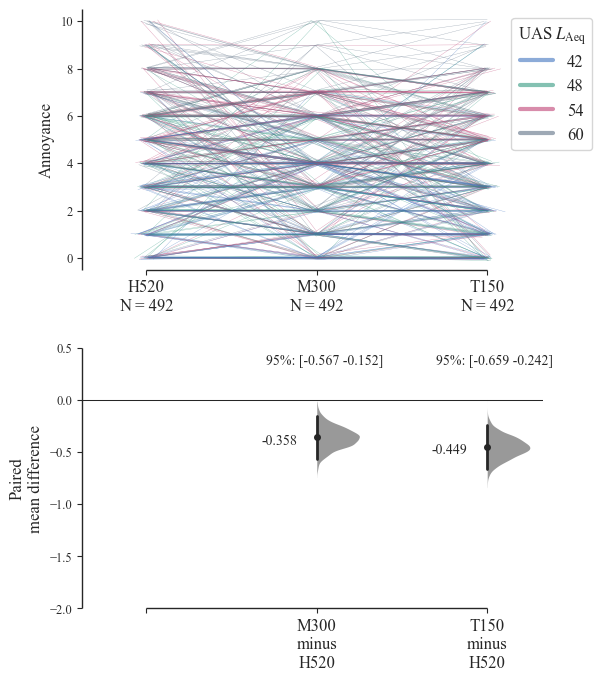

In [19]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(6, 3.5))
dataPkMD = dataPkloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                       custom_palette=mycolours, es_marker_size=4, contrast_ylim=(-2, 0.5), float_contrast=True,
                                       contrast_show_es=True, es_sf=3,
                                       legend_kwargs={'loc': 'upper center', 'title': r"UAS $L_\mathrm{Aeq}$", 'fontsize': 12,
                                                      'frameon': True, 'title_fontsize': 12}, ax=ax)
diffs = dataPkloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values
# label results
for ii, diffrow in enumerate(np.round(diffs, 3)):
    #ax.text(x=0.8 + ii, y=-3.4, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtATypeParkDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtATypeParkDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataPkloadBL.mean_diff.statistical_tests])

dataPkMD;
dataPkloadBL.mean_diff.statistical_tests


In [20]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataPkloadBL.cohens_d.statistical_tests])
dataPkloadBL.cohens_d.statistical_tests


control  test  control_N  test_N effect_size is_paired  difference  ci  \
0    H520  M300        492     492   Cohen's d  baseline   -0.143211  95   
1    H520  T150        492     492   Cohen's d  baseline   -0.177829  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0 -0.224773 -0.060372              0.0006         0.001376   
1 -0.261016 -0.094142              0.0010         0.000021   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             23542.0                  0.000754                     3.390566  
1             27984.5                  0.000028                     4.231828

control  test  control_N  test_N      effect_size is_paired  difference  ci  \
0    H520  M300        492     492  mean difference  baseline   -0.085366  95   
1    H520  T150        492     492  mean difference  baseline   -0.197154  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0 -0.268293  0.097561            0.350530         0.205018   
1 -0.376016 -0.022358            0.030194         0.006711   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             27046.0                  0.374111                     0.889610  
1             23282.5                  0.031394                     2.158231

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


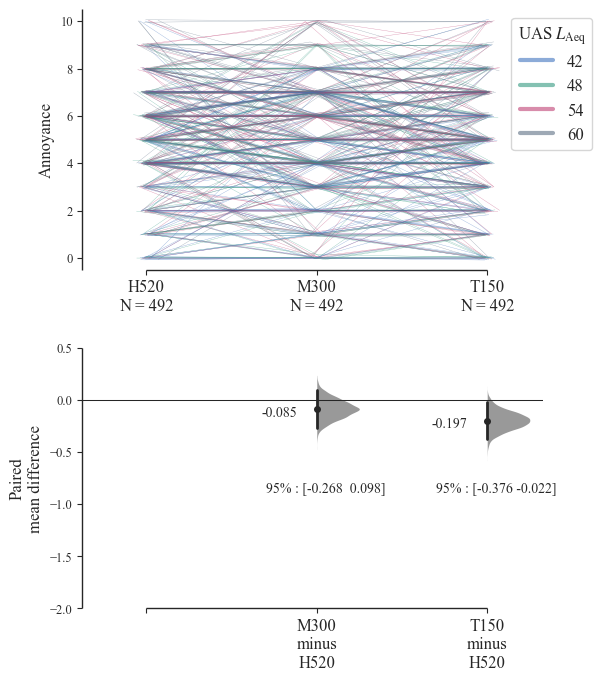

In [21]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(6, 3.5))
dataStMD = dataStloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=54554,
                                       custom_palette=mycolours, es_marker_size=4, contrast_ylim=(-2, 0.5), float_contrast=True,
                                       contrast_show_es=True, es_sf=3,
                                       legend_kwargs={'loc': 'upper center', 'title': r"UAS $L_\mathrm{Aeq}$", 'fontsize': 12,
                                                      'frameon': True, 'title_fontsize': 12}, ax=ax)

diffs = np.round(dataStloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-9.2, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-9.9, s="95% : " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtATypeStreetDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtATypeStreetDabest.pdf"),
                format='pdf', bbox_inches='tight')

out = pd.concat([out, dataStloadBL.mean_diff.statistical_tests])

dataStMD;
dataStloadBL.mean_diff.statistical_tests


In [22]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataStloadBL.cohens_d.statistical_tests])
dataStloadBL.cohens_d.statistical_tests


control  test  control_N  test_N effect_size is_paired  difference  ci  \
0    H520  M300        492     492   Cohen's d  baseline   -0.034743  95   
1    H520  T150        492     492   Cohen's d  baseline   -0.079948  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0 -0.108488  0.041185            0.350530         0.205018   
1 -0.151371 -0.008359            0.030194         0.006711   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             27046.0                  0.374111                     0.889610  
1             23282.5                  0.031394                     2.158231

In [23]:
# assign data for processing
dataPkHiloadBL = dabest.load(data=dataPk.loc[dataPk['UASLAeq'] == '60'], idx=("H520", "M300", "T150"), x='UASType', y='Annoyance', paired='baseline',
                             id_col='dummyID', resamples=5000, random_seed=12345)
dataStHiloadBL = dabest.load(data=dataSt.loc[dataSt['UASLAeq'] == '60'], idx=("H520", "M300", "T150"), x='UASType', y='Annoyance', paired='baseline',
                             id_col='dummyID', resamples=5000, random_seed=999)


control  test  control_N  test_N      effect_size is_paired  difference  ci  \
0    H520  M300        123     123  mean difference  baseline   -0.943089  95   
1    H520  T150        123     123  mean difference  baseline   -0.747967  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0 -1.382114 -0.504065              0.0004         0.000034   
1 -1.219512 -0.325203              0.0024         0.001863   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              1083.5                  0.000043                     4.245150  
1              1938.0                  0.001167                     3.325376

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


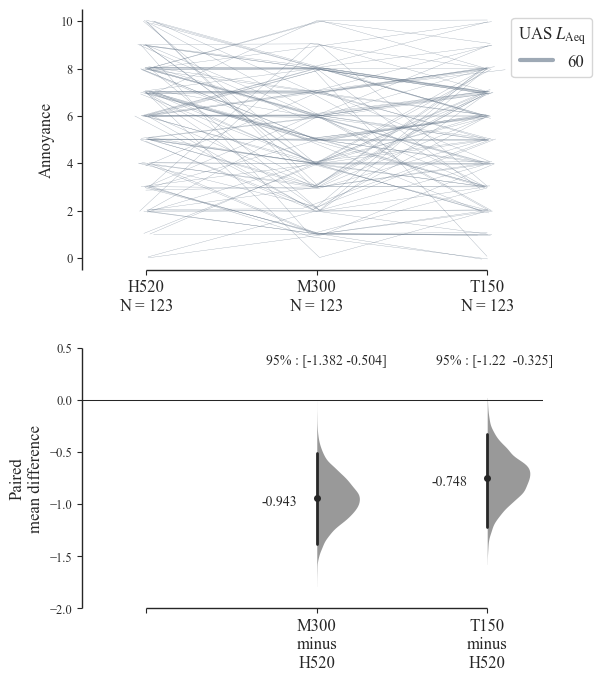

In [24]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(6, 3.5))
dataPkHiMD = dataPkHiloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                           contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                           slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                           custom_palette=mycolours[3:], es_marker_size=4, contrast_ylim=(-2, 0.5), float_contrast=True,
                                           contrast_show_es=True, es_sf=3,                                           
                                           legend_kwargs={'loc': 'upper center', 'title': r"UAS $L_\mathrm{Aeq}$", 'fontsize': 12,
                                                          'frameon': True, 'title_fontsize': 12}, ax=ax)
diffs = np.round(dataPkHiloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-3.4, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95% : " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtATypeParkHiDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtATypeParkHiDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataPkHiloadBL.mean_diff.statistical_tests])

dataPkHiMD;
dataPkHiloadBL.mean_diff.statistical_tests


In [25]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataPkHiloadBL.cohens_d.statistical_tests])
dataPkHiloadBL.cohens_d.statistical_tests


control  test  control_N  test_N effect_size is_paired  difference  ci  \
0    H520  M300        123     123   Cohen's d  baseline   -0.385177  95   
1    H520  T150        123     123   Cohen's d  baseline   -0.306181  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0 -0.569867 -0.198468              0.0004         0.000034   
1 -0.497649 -0.124149              0.0024         0.001863   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              1083.5                  0.000043                     4.245150  
1              1938.0                  0.001167                     3.325376

control  test  control_N  test_N      effect_size is_paired  difference  ci  \
0    H520  M300        123     123  mean difference  baseline   -0.219512  95   
1    H520  T150        123     123  mean difference  baseline   -0.341463  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0 -0.650407  0.170732            0.315337         0.263260   
1 -0.666667 -0.040650            0.039192         0.026306   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              1773.5                  0.297701                     1.045843  
1              1334.0                  0.032420                     2.163910

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


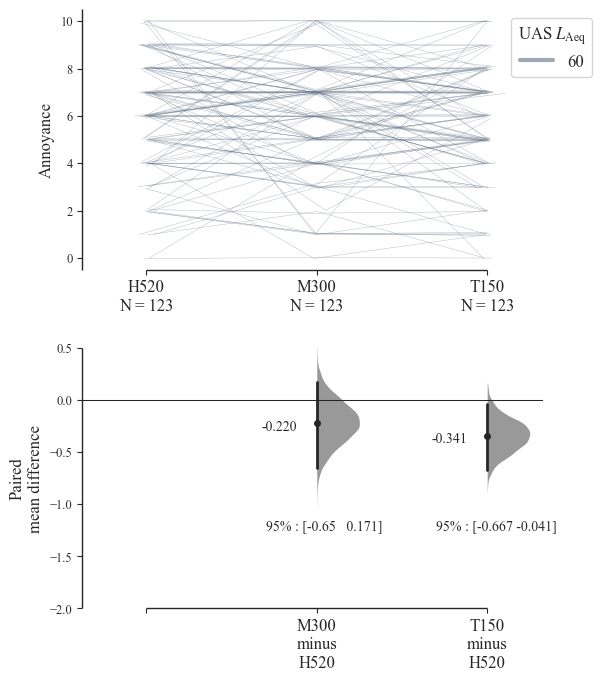

In [26]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(6, 3.5))
dataStHiMD = dataStHiloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                           contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                           slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                           custom_palette=mycolours[3:], es_marker_size=4, contrast_ylim=(-2, 0.5), float_contrast=True,
                                           contrast_show_es=True, es_sf=3,
                                           legend_kwargs={'loc': 'upper center', 'title': r"UAS $L_\mathrm{Aeq}$", 'fontsize': 12,
                                                          'frameon': True, 'title_fontsize': 12}, ax=ax)
diffs = np.round(dataStHiloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.2, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-11.5, s="95% : " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtATypeStreetHiDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtATypeStreetHiDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataStHiloadBL.mean_diff.statistical_tests])

dataStHiMD;
dataStHiloadBL.mean_diff.statistical_tests


In [27]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataStHiloadBL.cohens_d.statistical_tests])
dataStHiloadBL.cohens_d.statistical_tests


control  test  control_N  test_N effect_size is_paired  difference  ci  \
0    H520  M300        123     123   Cohen's d  baseline   -0.092979  95   
1    H520  T150        123     123   Cohen's d  baseline   -0.142476  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0 -0.275418  0.075336            0.315337         0.263260   
1 -0.281317 -0.015878            0.039192         0.026306   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              1773.5                  0.297701                     1.045843  
1              1334.0                  0.032420                     2.163910

#### Flight operation

In [28]:
# select subset of data for analysis and sort
data = dataBySubjTestA[~dataBySubjTestA['Recording'].str.contains("PwrScale")]
data = data[data['UASType'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'AmbientEnv', 'UASLAeq', 'UASType', 'UASOperation', 'Annoyance']]
data.sort_values(by=['ID#', 'UASLAeq', 'UASType', 'AmbientEnv', 'UASOperation'], inplace=True)

dataPk = data.loc[data['AmbientEnv'] == "Park", :]
dataSt = data.loc[data['AmbientEnv'] == "Street", :]

# create a dummy pairing ID
data['dummyID'] = np.repeat(np.arange(1, len(data['ID#'])//len(data['UASOperation'].unique()) + 1, dtype=int), len(data['UASOperation'].unique()), axis=0)
dataPk['dummyID'] = np.repeat(np.arange(1, len(dataPk['ID#'])//len(dataPk['UASOperation'].unique()) + 1, dtype=int), len(dataPk['UASOperation'].unique()), axis=0)
dataSt['dummyID'] = np.repeat(np.arange(1, len(dataSt['ID#'])//len(dataSt['UASOperation'].unique()) + 1, dtype=int), len(dataSt['UASOperation'].unique()), axis=0)


In [29]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=("Flyby", "Landing", "Takeoff"), x='UASOperation', y='Annoyance',
                         paired='baseline', id_col='dummyID', resamples=5000, random_seed=35941)
dataPkloadBL = dabest.load(data=dataPk, idx=("Flyby", "Landing", "Takeoff"), x='UASOperation', y='Annoyance',
                           paired='baseline', id_col='dummyID', resamples=5000, random_seed=4444)
dataStloadBL = dabest.load(data=dataSt, idx=("Flyby", "Landing", "Takeoff"), x='UASOperation', y='Annoyance',
                           paired='baseline', id_col='dummyID', resamples=5000, random_seed=6564)


control     test  control_N  test_N      effect_size is_paired  difference  \
0   Flyby  Landing        984     984  mean difference  baseline    0.311992   
1   Flyby  Takeoff        984     984  mean difference  baseline    0.445122   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.174797  0.452236              0.0002     8.734782e-07   
1  95  0.298780  0.591463              0.0002     1.466700e-09   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             98564.0              1.366143e-05                    -4.371361  
1             99960.5              3.440872e-09                    -5.963452

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


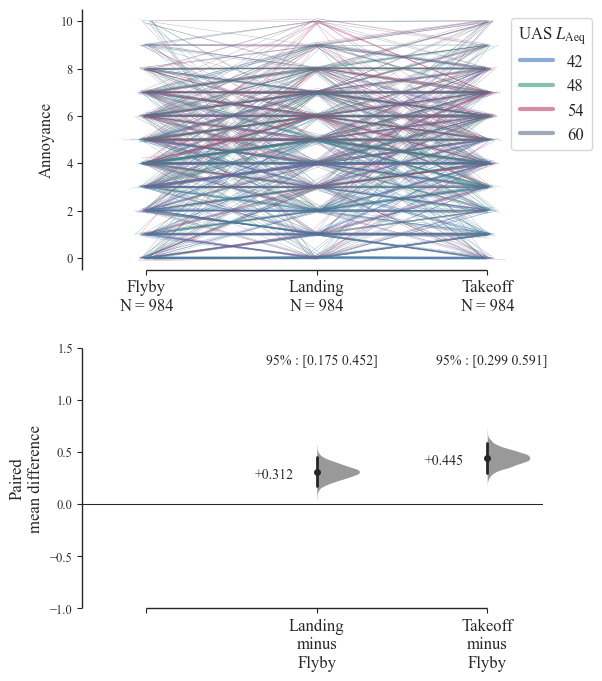

In [30]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(6, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                   contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                   slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                   custom_palette=mycolours, es_marker_size=4, contrast_ylim=(-1, 1.5), float_contrast=True,
                                   contrast_show_es=True, es_sf=3,
                                   legend_kwargs={'loc': 'upper center', 'title': r"UAS $L_\mathrm{Aeq}$", 'fontsize': 12,
                                                  'frameon': True, 'title_fontsize': 12}, ax=ax)
diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-3.4, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95% : " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtAOpDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtAOpDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [31]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control     test  control_N  test_N effect_size is_paired  difference  ci  \
0   Flyby  Landing        984     984   Cohen's d  baseline    0.125200  95   
1   Flyby  Takeoff        984     984   Cohen's d  baseline    0.177272  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.069658  0.181372              0.0002     8.734782e-07   
1  0.119462  0.235563              0.0002     1.466700e-09   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             98564.0              1.366143e-05                    -4.371361  
1             99960.5              3.440872e-09                    -5.963452

control     test  control_N  test_N      effect_size is_paired  difference  \
0   Flyby  Landing        492     492  mean difference  baseline    0.353659   
1   Flyby  Takeoff        492     492  mean difference  baseline    0.430894   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.160569  0.563008              0.0006         0.000191   
1  95  0.225610  0.638211              0.0002         0.000087   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             24936.0                  0.000730                    -3.399509  
1             26950.5                  0.000068                    -4.017696

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


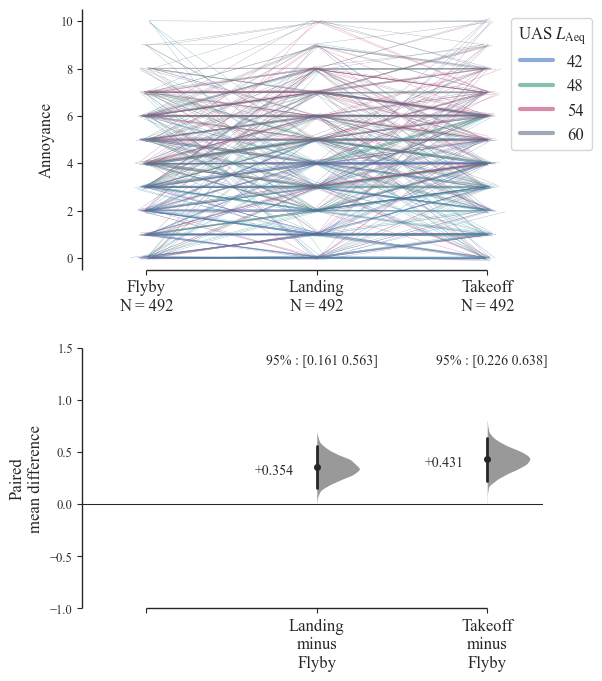

In [32]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(6, 3.5))
dataPkMD = dataPkloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                       custom_palette=mycolours, es_marker_size=4, contrast_ylim=(-1, 1.5), float_contrast=True,
                                       contrast_show_es=True, es_sf=3,
                                       legend_kwargs={'loc': 'upper center', 'title': r"UAS $L_\mathrm{Aeq}$", 'fontsize': 12,
                                                      'frameon': True, 'title_fontsize': 12}, ax=ax)
diffs = np.round(dataPkloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-3.4, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95% : " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtAOpParkDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtAOpParkDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataPkloadBL.mean_diff.statistical_tests])

dataPkMD;
dataPkloadBL.mean_diff.statistical_tests


In [33]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataPkloadBL.cohens_d.statistical_tests])
dataPkloadBL.cohens_d.statistical_tests


control     test  control_N  test_N effect_size is_paired  difference  ci  \
0   Flyby  Landing        492     492   Cohen's d  baseline    0.143209  95   
1   Flyby  Takeoff        492     492   Cohen's d  baseline    0.175236  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.064627  0.227708              0.0006         0.000191   
1  0.092028  0.261328              0.0002         0.000087   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             24936.0                  0.000730                    -3.399509  
1             26950.5                  0.000068                    -4.017696

control     test  control_N  test_N      effect_size is_paired  difference  \
0   Flyby  Landing        492     492  mean difference  baseline    0.270325   
1   Flyby  Takeoff        492     492  mean difference  baseline    0.459350   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.077236  0.461382            0.004799         0.001284   
1  95  0.258130  0.668699            0.000200         0.000004   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             24420.5                  0.005928                    -2.763793  
1             23199.0                  0.000012                    -4.419069

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


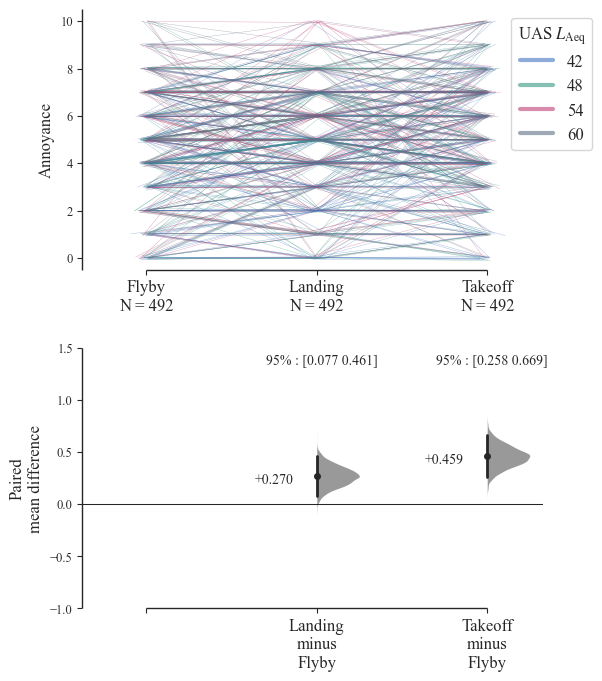

In [34]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(6, 3.5))
dataStMD = dataStloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                       custom_palette=mycolours, es_marker_size=4, contrast_ylim=(-1, 1.5), float_contrast=True,
                                       contrast_show_es=True, es_sf=3,
                                       legend_kwargs={'loc': 'upper center', 'title': r"UAS $L_\mathrm{Aeq}$", 'fontsize': 12,
                                                      'frameon': True, 'title_fontsize': 12}, ax=ax)

diffs = np.round(dataStloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-3.4, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95% : " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtAOpStreetDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtAOpStreetDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataStloadBL.mean_diff.statistical_tests])    

dataStMD;
dataStloadBL.mean_diff.statistical_tests


In [35]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataStloadBL.cohens_d.statistical_tests])
dataStloadBL.cohens_d.statistical_tests


control     test  control_N  test_N effect_size is_paired  difference  ci  \
0   Flyby  Landing        492     492   Cohen's d  baseline    0.110748  95   
1   Flyby  Takeoff        492     492   Cohen's d  baseline    0.185207  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.031931  0.189216            0.004799         0.001284   
1  0.103246  0.270884            0.000200         0.000004   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             24420.5                  0.005928                    -2.763793  
1             23199.0                  0.000012                    -4.419069

In [36]:
# assign data for processing
dataHiloadBL = dabest.load(data=data.loc[data['UASLAeq'] == '60'], idx=("Flyby", "Landing", "Takeoff"),
                           x='UASOperation', y='Annoyance', paired='baseline',
                           id_col='dummyID', resamples=5000, random_seed=808)


control     test  control_N  test_N      effect_size is_paired  difference  \
0   Flyby  Landing        246     246  mean difference  baseline    0.333333   
1   Flyby  Takeoff        246     246  mean difference  baseline    0.796748   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.028455  0.626016            0.038192         0.009347   
1  95  0.495935  1.121951            0.000200         0.000003   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              7363.0                  0.035173                    -2.118107  
1              6319.5                  0.000001                    -4.981410

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


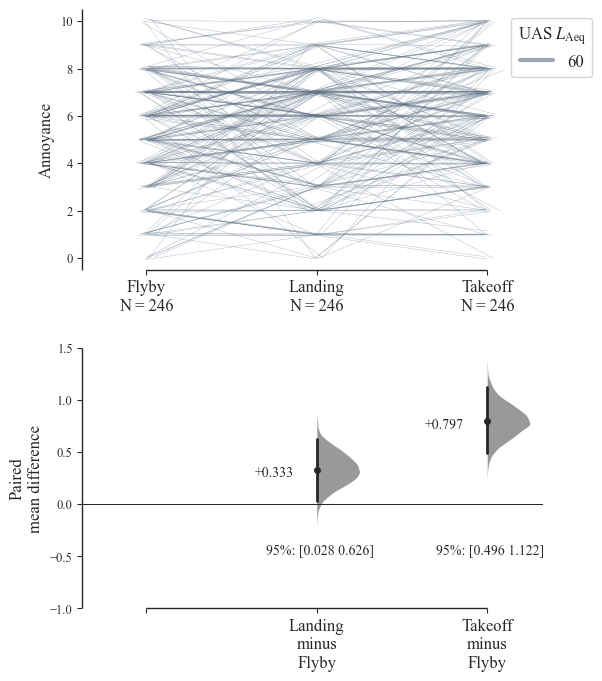

In [37]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(6, 3.5))
dataHiMD = dataHiloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                       custom_palette=mycolours[3:], es_marker_size=4, contrast_ylim=(-1, 1.5), float_contrast=True,
                                       contrast_show_es=True, es_sf=3,
                                       legend_kwargs={'loc': 'upper center', 'title': r"UAS $L_\mathrm{Aeq}$", 'fontsize': 12,
                                                      'frameon': True, 'title_fontsize': 12}, ax=ax)
diffs = np.round(dataHiloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-12.5, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtAOpHiDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtAOpHiDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataHiloadBL.mean_diff.statistical_tests])

dataHiMD;
dataHiloadBL.mean_diff.statistical_tests


In [38]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataHiloadBL.cohens_d.statistical_tests])
dataHiloadBL.cohens_d.statistical_tests


control     test  control_N  test_N effect_size is_paired  difference  ci  \
0   Flyby  Landing        246     246   Cohen's d  baseline    0.138743  95   
1   Flyby  Takeoff        246     246   Cohen's d  baseline    0.328772  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.011994  0.264158            0.038192         0.009347   
1  0.203651  0.463129            0.000200         0.000003   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              7363.0                  0.035173                    -2.118107  
1              6319.5                  0.000001                    -4.981410

### UAS type and operation combined

In [39]:
# select subset of data for analysis and sort
data = dataBySubjTestA[~dataBySubjTestA['Recording'].str.contains("PwrScale")]
data = data[data['UASType'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'AmbientEnv', 'UASLAeq', 'UASType', 'UASOperation', 'Annoyance']]
data.sort_values(by=['AmbientEnv', 'ID#', 'UASLAeq', 'UASType', 'UASOperation'], inplace=True)

# take highest LAeq in park env
dataPk = data.loc[(data['AmbientEnv'] == "Park"), :]
dataPk['UASTypeOp'] = dataPk['UASType'].astype(str) + " " + dataPk['UASOperation'].astype(str)
dataPk.sort_values(by=['ID#', 'UASLAeq', 'UASTypeOp'], inplace=True)

# take highest LAeq in park env
dataSt = data.loc[(data['AmbientEnv'] == "Street"), :]
dataSt['UASTypeOp'] = dataSt['UASType'].astype(str) + " " + dataSt['UASOperation'].astype(str)
dataSt.sort_values(by=['ID#', 'UASLAeq', 'UASTypeOp'], inplace=True)

# create a dummy pairing ID
data['UASTypeOp'] = data['UASType'].astype(str) + " " + data['UASOperation'].astype(str)
data.sort_values(by=['AmbientEnv', 'ID#', 'UASLAeq', 'UASTypeOp'], inplace=True)

data['dummyID'] = np.repeat(np.arange(1, len(data['ID#'])//len(data['UASTypeOp'].unique()) + 1, dtype=int), len(data['UASTypeOp'].unique()), axis=0)
dataPk['dummyID'] = np.repeat(np.arange(1, len(dataPk['ID#'])//len(dataPk['UASTypeOp'].unique()) + 1, dtype=int), len(dataPk['UASTypeOp'].unique()), axis=0)
dataSt['dummyID'] = np.repeat(np.arange(1, len(dataSt['ID#'])//len(dataSt['UASTypeOp'].unique()) + 1, dtype=int), len(dataSt['UASTypeOp'].unique()), axis=0)


In [40]:
# assign data for processing

dataloadBL = dabest.load(data=data,  idx=("T150 Flyby", "M300 Flyby", "H520 Flyby",
                                          "T150 Landing", "M300 Landing", "H520 Landing",
                                          "T150 Takeoff", "M300 Takeoff", "H520 Takeoff"), x='UASTypeOp', y='Annoyance',
                         paired='baseline', id_col='dummyID', resamples=5000, random_seed=42828412)

dataPkloadBL = dabest.load(data=dataPk,  idx=("T150 Flyby", "M300 Flyby", "H520 Flyby",
                                              "T150 Landing", "M300 Landing", "H520 Landing",
                                              "T150 Takeoff", "M300 Takeoff", "H520 Takeoff"), x='UASTypeOp', y='Annoyance',
                           paired='baseline', id_col='dummyID', resamples=5000, random_seed=82108)
dataStloadBL = dabest.load(data=dataSt,  idx=("T150 Flyby", "M300 Flyby", "H520 Flyby",
                                              "T150 Landing", "M300 Landing", "H520 Landing",
                                              "T150 Takeoff", "M300 Takeoff", "H520 Takeoff"), x='UASTypeOp', y='Annoyance',
                           paired='baseline', id_col='dummyID', resamples=5000, random_seed=1198232)

control          test  control_N  test_N      effect_size is_paired  \
0  T150 Flyby    M300 Flyby        328     328  mean difference  baseline   
1  T150 Flyby    H520 Flyby        328     328  mean difference  baseline   
2  T150 Flyby  T150 Landing        328     328  mean difference  baseline   
3  T150 Flyby  M300 Landing        328     328  mean difference  baseline   
4  T150 Flyby  H520 Landing        328     328  mean difference  baseline   
5  T150 Flyby  T150 Takeoff        328     328  mean difference  baseline   
6  T150 Flyby  M300 Takeoff        328     328  mean difference  baseline   
7  T150 Flyby  H520 Takeoff        328     328  mean difference  baseline   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0    0.094512  95 -0.143293  0.317073            0.438112     1.659381e-01   
1    0.323171  95  0.109756  0.542683            0.004199     2.803496e-03   
2    0.335366  95  0.067073  0.585366            0.009198     7.376186e-03   
3    0.393293  95  0.152439  0.621951            0.001000     3.304430e-04   
4    0.625000  95  0.375000  0.875000            0.000200     1.086049e-07   
5    0.414634  95  0.155488  0.667683            0.001800     7.971033e-04   
6    0.567073  95  0.323171  0.795732            0.000200     3.628993e-06   
7    0.771341  95  0.503049  1.027439            0.000200     1.918921e-08   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             10970.0              4.241502e-01                    -0.800244  
1             10619.0              3.438486e-03                    -2.947074  
2             11421.5              1.140130e-02                    -2.544547  
3             11456.0              9.682409e-04                    -3.329832  
4              9182.5              1.814010e-06                    -4.861293  
5             11098.5              1.433034e-03                    -3.215333  
6              8409.0              5.337762e-06                    -4.627711  
7             10135.5              1.125239e-08                    -5.860735

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


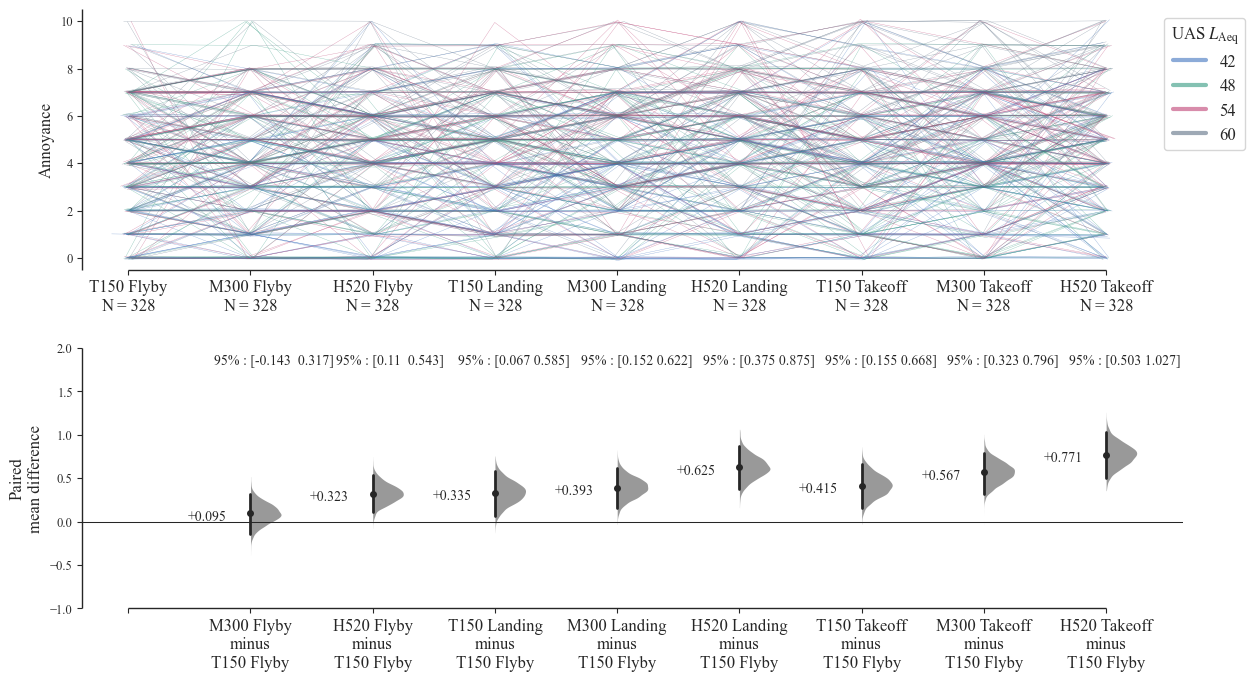

In [41]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(12.5, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                   contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                   slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                   custom_palette=mycolours[0:4], es_marker_size=4, contrast_ylim=(-1, 2), float_contrast=True,
                                   contrast_show_es=True, es_sf=3,
                                   legend_kwargs={'loc': 'upper center', 'title': r"UAS $L_\mathrm{Aeq}$", 'fontsize': 12,
                                                  'frameon': True, 'title_fontsize': 12}, ax=ax)
diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-3.4, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95% : " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtATypeOpDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtATypeOpDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [42]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control          test  control_N  test_N effect_size is_paired  \
0  T150 Flyby    M300 Flyby        328     328   Cohen's d  baseline   
1  T150 Flyby    H520 Flyby        328     328   Cohen's d  baseline   
2  T150 Flyby  T150 Landing        328     328   Cohen's d  baseline   
3  T150 Flyby  M300 Landing        328     328   Cohen's d  baseline   
4  T150 Flyby  H520 Landing        328     328   Cohen's d  baseline   
5  T150 Flyby  T150 Takeoff        328     328   Cohen's d  baseline   
6  T150 Flyby  M300 Takeoff        328     328   Cohen's d  baseline   
7  T150 Flyby  H520 Takeoff        328     328   Cohen's d  baseline   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0    0.038661  95 -0.056796  0.131360            0.438112     1.659381e-01   
1    0.130648  95  0.045006  0.219179            0.004199     2.803496e-03   
2    0.136109  95  0.027418  0.240110            0.009198     7.376186e-03   
3    0.160460  95  0.062594  0.256846            0.001000     3.304430e-04   
4    0.249409  95  0.147416  0.352336            0.000200     1.086049e-07   
5    0.164140  95  0.062209  0.264266            0.001800     7.971033e-04   
6    0.229319  95  0.132053  0.324829            0.000200     3.628993e-06   
7    0.311304  95  0.203803  0.416670            0.000200     1.918921e-08   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0             10970.0              4.241502e-01                    -0.800244  
1             10619.0              3.438486e-03                    -2.947074  
2             11421.5              1.140130e-02                    -2.544547  
3             11456.0              9.682409e-04                    -3.329832  
4              9182.5              1.814010e-06                    -4.861293  
5             11098.5              1.433034e-03                    -3.215333  
6              8409.0              5.337762e-06                    -4.627711  
7             10135.5              1.125239e-08                    -5.860735

control          test  control_N  test_N      effect_size is_paired  \
0  T150 Flyby    M300 Flyby        164     164  mean difference  baseline   
1  T150 Flyby    H520 Flyby        164     164  mean difference  baseline   
2  T150 Flyby  T150 Landing        164     164  mean difference  baseline   
3  T150 Flyby  M300 Landing        164     164  mean difference  baseline   
4  T150 Flyby  H520 Landing        164     164  mean difference  baseline   
5  T150 Flyby  T150 Takeoff        164     164  mean difference  baseline   
6  T150 Flyby  M300 Takeoff        164     164  mean difference  baseline   
7  T150 Flyby  H520 Takeoff        164     164  mean difference  baseline   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0    0.280488  95 -0.036585  0.615854            0.098180     7.661721e-02   
1    0.451220  95  0.152439  0.792683            0.005199     9.464494e-03   
2    0.615854  95  0.280488  0.981707            0.000600     1.621305e-03   
3    0.359756  95  0.042683  0.670732            0.037592     2.308370e-02   
4    0.817073  95  0.451220  1.213415            0.000200     2.140203e-05   
5    0.359756  95  0.000000  0.756098            0.069386     9.349323e-02   
6    0.609756  95  0.286585  0.945122            0.000200     5.676448e-04   
7    1.054878  95  0.689024  1.420732            0.000200     5.238470e-07   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              2611.5              1.005645e-01                    -1.651487  
1              2706.5              7.273684e-03                    -2.718222  
2              2542.0              8.799697e-04                    -3.388928  
3              3187.5              3.248925e-02                    -2.156767  
4              2232.5              5.024485e-05                    -4.165546  
5              3320.5              6.650658e-02                    -1.847367  
6              2424.0              4.015446e-04                    -3.613871  
7              2117.5              1.629070e-07                    -5.474587

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


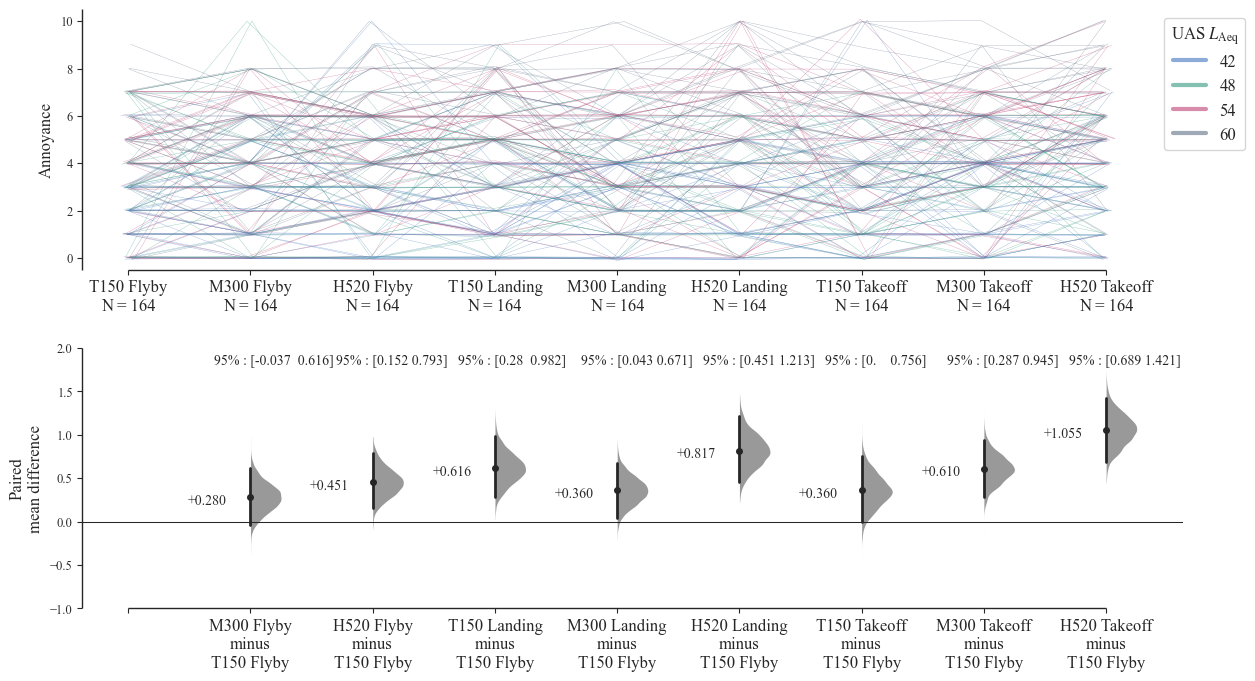

In [43]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(12.5, 3.5))
dataPkMD = dataPkloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                       custom_palette=mycolours[0:4], es_marker_size=4, contrast_ylim=(-1, 2), float_contrast=True,
                                       contrast_show_es=True, es_sf=3,
                                       legend_kwargs={'loc': 'upper center', 'title': r"UAS $L_\mathrm{Aeq}$", 'fontsize': 12,
                                                      'frameon': True, 'title_fontsize': 12}, ax=ax)
diffs = np.round(dataPkloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-3.4, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95% : " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtAPkTypeOpDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtAPkTypeOpDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataPkloadBL.mean_diff.statistical_tests])

dataPkMD;
dataPkloadBL.mean_diff.statistical_tests


In [44]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataPkloadBL.cohens_d.statistical_tests])
dataPkloadBL.cohens_d.statistical_tests


control          test  control_N  test_N effect_size is_paired  \
0  T150 Flyby    M300 Flyby        164     164   Cohen's d  baseline   
1  T150 Flyby    H520 Flyby        164     164   Cohen's d  baseline   
2  T150 Flyby  T150 Landing        164     164   Cohen's d  baseline   
3  T150 Flyby  M300 Landing        164     164   Cohen's d  baseline   
4  T150 Flyby  H520 Landing        164     164   Cohen's d  baseline   
5  T150 Flyby  T150 Takeoff        164     164   Cohen's d  baseline   
6  T150 Flyby  M300 Takeoff        164     164   Cohen's d  baseline   
7  T150 Flyby  H520 Takeoff        164     164   Cohen's d  baseline   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0    0.118778  95 -0.015620  0.262608            0.098180     7.661721e-02   
1    0.190719  95  0.064082  0.333781            0.005199     9.464494e-03   
2    0.255822  95  0.117895  0.408160            0.000600     1.621305e-03   
3    0.154951  95  0.019853  0.293825            0.037592     2.308370e-02   
4    0.326214  95  0.178402  0.478751            0.000200     2.140203e-05   
5    0.148812  95  0.002601  0.310356            0.069386     9.349323e-02   
6    0.260034  95  0.120406  0.401062            0.000200     5.676448e-04   
7    0.434757  95  0.283147  0.587144            0.000200     5.238470e-07   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              2611.5              1.005645e-01                    -1.651487  
1              2706.5              7.273684e-03                    -2.718222  
2              2542.0              8.799697e-04                    -3.388928  
3              3187.5              3.248925e-02                    -2.156767  
4              2232.5              5.024485e-05                    -4.165546  
5              3320.5              6.650658e-02                    -1.847367  
6              2424.0              4.015446e-04                    -3.613871  
7              2117.5              1.629070e-07                    -5.474587

control          test  control_N  test_N      effect_size is_paired  \
0  T150 Flyby    M300 Flyby        164     164  mean difference  baseline   
1  T150 Flyby    H520 Flyby        164     164  mean difference  baseline   
2  T150 Flyby  T150 Landing        164     164  mean difference  baseline   
3  T150 Flyby  M300 Landing        164     164  mean difference  baseline   
4  T150 Flyby  H520 Landing        164     164  mean difference  baseline   
5  T150 Flyby  T150 Takeoff        164     164  mean difference  baseline   
6  T150 Flyby  M300 Takeoff        164     164  mean difference  baseline   
7  T150 Flyby  H520 Takeoff        164     164  mean difference  baseline   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0   -0.091463  95 -0.445122  0.195122            0.601080         0.816491   
1    0.195122  95 -0.097561  0.469512            0.186563         0.109890   
2    0.054878  95 -0.329268  0.414634            0.749850         0.531751   
3    0.426829  95  0.091463  0.737805            0.009798         0.005608   
4    0.432927  95  0.085366  0.725610            0.006799         0.001047   
5    0.469512  95  0.115854  0.780488            0.005199         0.001750   
6    0.524390  95  0.164634  0.859756            0.003599         0.001730   
7    0.487805  95  0.134146  0.817073            0.005399         0.004959   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              2869.0                  0.576389                     0.559793  
1              2627.0                  0.174730                    -1.363102  
2              3169.5                  0.771865                    -0.290419  
3              2597.5                  0.011868                    -2.544637  
4              2366.5                  0.009739                    -2.615754  
5              2275.5                  0.006284                    -2.768487  
6              1812.0                  0.003729                    -2.942669  
7              3016.5                  0.006565                    -2.753513

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


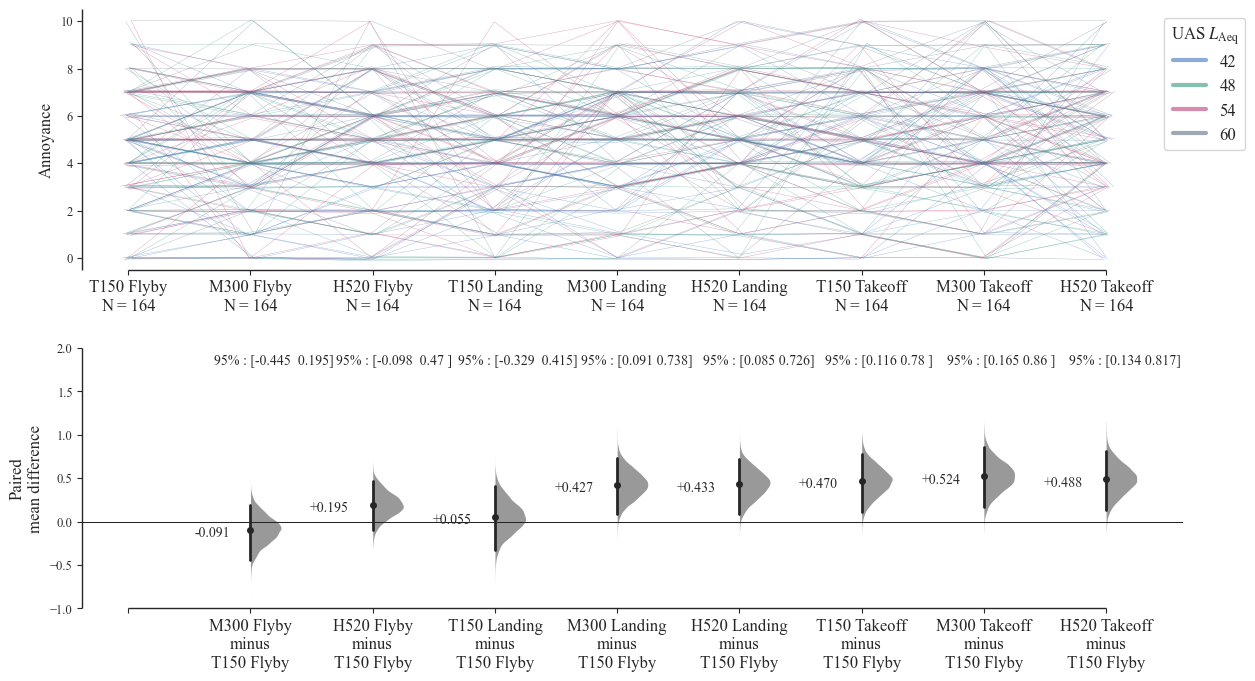

In [45]:
# calculate effect sizes and plot
fig, ax = plt.subplots(figsize=(12.5, 3.5))
dataStMD = dataStloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                       custom_palette=mycolours[0:4], es_marker_size=4, contrast_ylim=(-1, 2), float_contrast=True,
                                       contrast_show_es=True, es_sf=3,
                                       legend_kwargs={'loc': 'upper center', 'title': r"UAS $L_\mathrm{Aeq}$", 'fontsize': 12,
                                                      'frameon': True, 'title_fontsize': 12}, ax=ax)
diffs = np.round(dataStloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-3.4, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95% : " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtAStTypeOpDabest.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtAStTypeOpDabest.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataStloadBL.mean_diff.statistical_tests])

dataStMD;
dataStloadBL.mean_diff.statistical_tests


In [46]:
# calculate effect sizes - Cohen's d
outd = pd.concat([outd, dataStloadBL.cohens_d.statistical_tests])
dataStloadBL.cohens_d.statistical_tests


control          test  control_N  test_N effect_size is_paired  \
0  T150 Flyby    M300 Flyby        164     164   Cohen's d  baseline   
1  T150 Flyby    H520 Flyby        164     164   Cohen's d  baseline   
2  T150 Flyby  T150 Landing        164     164   Cohen's d  baseline   
3  T150 Flyby  M300 Landing        164     164   Cohen's d  baseline   
4  T150 Flyby  H520 Landing        164     164   Cohen's d  baseline   
5  T150 Flyby  T150 Takeoff        164     164   Cohen's d  baseline   
6  T150 Flyby  M300 Takeoff        164     164   Cohen's d  baseline   
7  T150 Flyby  H520 Takeoff        164     164   Cohen's d  baseline   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0   -0.037464  95 -0.175467  0.084212            0.601080         0.816491   
1    0.078499  95 -0.036357  0.194062            0.186563         0.109890   
2    0.022416  95 -0.129394  0.173453            0.749850         0.531751   
3    0.174305  95  0.038392  0.307535            0.009798         0.005608   
4    0.178591  95  0.034155  0.305119            0.006799         0.001047   
5    0.187563  95  0.046619  0.314040            0.005199         0.001750   
6    0.210793  95  0.065597  0.348282            0.003599         0.001730   
7    0.198481  95  0.055283  0.336951            0.005399         0.004959   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              2869.0                  0.576389                     0.559793  
1              2627.0                  0.174730                    -1.363102  
2              3169.5                  0.771865                    -0.290419  
3              2597.5                  0.011868                    -2.544637  
4              2366.5                  0.009739                    -2.615754  
5              2275.5                  0.006284                    -2.768487  
6              1812.0                  0.003729                    -2.942669  
7              3016.5                  0.006565                    -2.753513

### AAM attitude

In [47]:
# select subset of data for analysis and sort
data = dataBySubjTestA
data = data[data['UASLAeq'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'UASLAeq', 'AAM_attitude', 'Annoyance']]


In [48]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=['Supportive', 'Ambivalent', 'Concerned', 'Neutral'],
                         x='AAM_attitude', y='Annoyance', resamples=5000, random_seed=3616)


control        test  control_N  test_N      effect_size is_paired  \
0  Supportive  Ambivalent        858     624  mean difference      None   
1  Supportive   Concerned        858     546  mean difference      None   
2  Supportive     Neutral        858    1170  mean difference      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0    0.592803  95  0.337995  0.836976              0.0002  3.290390e-06   
1    0.632867  95  0.375458  0.884449              0.0002  1.664511e-06   
2    1.328594  95  1.110101  1.559907              0.0002  2.859394e-29   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0        -4.670084       5.770857e-06             -4.551185   
1        -4.812701       3.755363e-06             -4.643006   
2       -11.433174       8.979513e-30            -11.516742   

   pvalue_mann_whitney  statistic_mann_whitney  
0         6.710828e-06                231324.5  
1         2.476898e-06                199573.5  
2         2.317014e-26                364345.5

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


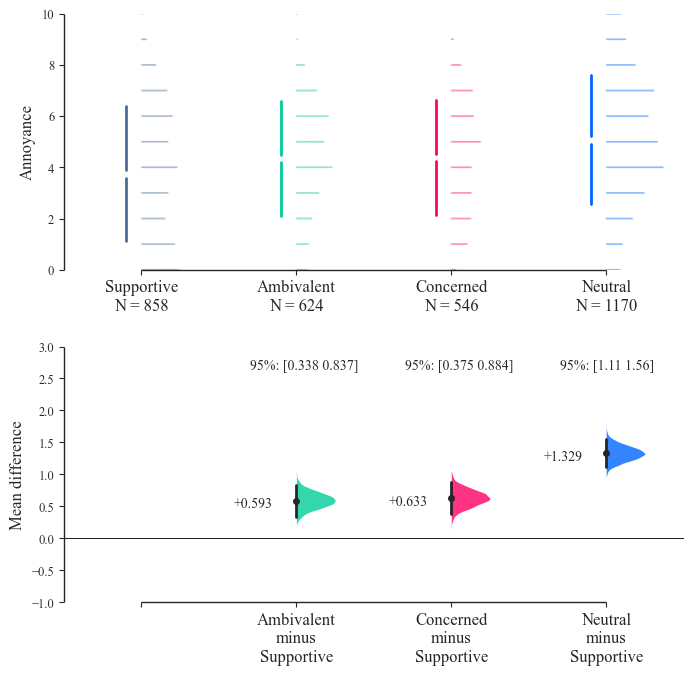

In [49]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                   raw_marker_size=0.005,
                                   swarmplot_kwargs={'alpha': 0.3},
                                   contrast_show_deltas=False,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette={'Neutral': mycolours[0],
                                                   'Ambivalent': mycolours[1],
                                                   'Concerned': mycolours[2],
                                                   'Supportive': mycolours[3]},
                                   swarm_desat=1,
                                   halfviolin_desat=1,
                                   bar_desat=1,
                                   es_marker_size=4,
                                   contrast_ylim=(-1, 3),
                                   ax=ax,
                                   )

diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-3.9, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtAAttDabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtAAttDabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [50]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control        test  control_N  test_N effect_size is_paired  \
0  Supportive  Ambivalent        858     624   Cohen's d      None   
1  Supportive   Concerned        858     546   Cohen's d      None   
2  Supportive     Neutral        858    1170   Cohen's d      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0    0.239449  95  0.135367  0.339727              0.0002  3.290390e-06   
1    0.254181  95  0.150671  0.357394              0.0002  1.664511e-06   
2    0.517639  95  0.429056  0.607492              0.0002  2.859394e-29   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0        -4.670084       5.770857e-06             -4.551185   
1        -4.812701       3.755363e-06             -4.643006   
2       -11.433174       8.979513e-30            -11.516742   

   pvalue_mann_whitney  statistic_mann_whitney  
0         6.710828e-06                231324.5  
1         2.476898e-06                199573.5  
2         2.317014e-26                364345.5

### Home residence area

In [51]:
# select subset of data for analysis and sort
data = dataBySubjTestA
data = data[data['UASLAeq'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'UASLAeq', 'Home_Area', 'Annoyance']]


In [52]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=['Urban', 'Suburban', 'Rural'],
                         x='Home_Area', y='Annoyance', resamples=5000, random_seed=80842)


control      test  control_N  test_N      effect_size is_paired  difference  \
0   Urban  Suburban       2106    1014  mean difference      None    0.706370   
1   Urban     Rural       2106      78  mean difference      None   -0.519468   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0  95  0.527175  0.872197            0.000200  1.896505e-15        -8.000883   
1  95 -1.025641  0.054606            0.081984  6.488741e-02         1.870556   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0       1.340707e-13             -7.435315         1.954577e-11   
1       8.685535e-02              1.712996         7.266550e-02   

   statistic_mann_whitney  
0                910678.5  
1                 91893.5

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


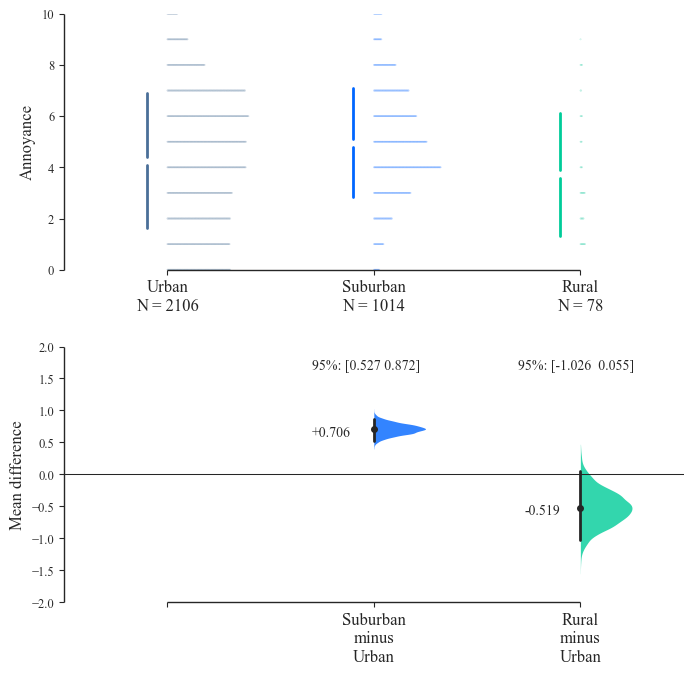

In [53]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                   raw_marker_size=0.005,
                                   swarmplot_kwargs={'alpha': 0.3},
                                   contrast_show_deltas=False,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette={'Suburban': mycolours[0],
                                                   'Rural': mycolours[1],
                                                   'Urban': mycolours[3]},
                                   swarm_desat=1,
                                   halfviolin_desat=1,
                                   bar_desat=1,
                                   es_marker_size=4,
                                   contrast_ylim=(-2, 2),
                                   ax=ax,
                                   )

diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-3.9, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtAAORDabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtAAORDabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [54]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control      test  control_N  test_N effect_size is_paired  difference  ci  \
0   Urban  Suburban       2106    1014   Cohen's d      None    0.284203  95   
1   Urban     Rural       2106      78   Cohen's d      None   -0.197518  95   

    bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0  0.210467  0.351086            0.000200  1.896505e-15        -8.000883   
1 -0.390260  0.021140            0.081984  6.488741e-02         1.870556   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0       1.340707e-13             -7.435315         1.954577e-11   
1       8.685535e-02              1.712996         7.266550e-02   

   statistic_mann_whitney  
0                910678.5  
1                 91893.5

## Part B

### Number of events

In [55]:
# select subset of data for analysis and sort
data = dataBySubjTestB
data = data[data['UASLAeq'] != "No UAS"]
data['UASEvents'] = data['UASEvents'].astype(int).astype(str)
data = data.loc[:, ['ID#', 'StimFile', 'UASEvents', 'UASLAeq', 'UASType', 'Annoyance']]
data.sort_values(by=['ID#', 'UASType', 'UASLAeq', 'UASEvents'], inplace=True)

dataLo = data.loc[data['UASLAeq'] == "54", :]
dataHi = data.loc[data['UASLAeq'] == "60", :]
dataLoH520 = data.loc[(data['UASType'] == "H520") & (data['UASLAeq'] == "54"), :]
dataLoT150 = data.loc[(data['UASType'] == "T150") & (data['UASLAeq'] == "54"), :]
dataHiH520 = data.loc[(data['UASType'] == "H520") & (data['UASLAeq'] == "60"), :]
dataHiT150 = data.loc[(data['UASType'] == "T150") & (data['UASLAeq'] == "60"), :]

# create dummy pairing IDs
for dataset in [data, dataLo, dataHi, dataLoH520, dataLoT150, dataHiH520, dataHiT150]:
    dataset['dummyID'] = np.repeat(np.arange(1, len(dataset['ID#'])//len(dataset['UASEvents'].unique()) + 1, dtype=int), len(dataset['UASEvents'].unique()), axis=0)


In [56]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=data['UASEvents'].unique(),
                         x='UASEvents', y='Annoyance', paired='baseline',
                         id_col='dummyID', resamples=5000, random_seed=888)
dataloadSQ = dabest.load(data=data, idx=data['UASEvents'].unique(),
                         x='UASEvents', y='Annoyance', paired='sequential',
                         id_col='dummyID', resamples=5000, random_seed=456)

dataLoloadBL = dabest.load(data=dataLo, idx=dataLo['UASEvents'].unique(),
                           x='UASEvents', y='Annoyance', paired='baseline',
                           id_col='dummyID', resamples=5000, random_seed=4373)
dataLoloadSQ = dabest.load(data=dataLo, idx=dataLo['UASEvents'].unique(),
                           x='UASEvents', y='Annoyance', paired='sequential',
                           id_col='dummyID', resamples=5000, random_seed=714)

dataHiloadBL = dabest.load(data=dataHi, idx=dataHi['UASEvents'].unique(),
                           x='UASEvents', y='Annoyance', paired='baseline',
                           id_col='dummyID', resamples=5000, random_seed=238)
dataHiloadSQ = dabest.load(data=dataHi, idx=dataHi['UASEvents'].unique(),
                           x='UASEvents', y='Annoyance', paired='sequential',
                           id_col='dummyID', resamples=5000, random_seed=99595)

dataLoH520loadBL = dabest.load(data=dataLoH520, idx=dataLoH520['UASEvents'].unique(),
                               x='UASEvents', y='Annoyance', paired='baseline',
                               id_col='dummyID', resamples=5000, random_seed=545)
dataLoH520loadSQ = dabest.load(data=dataLoH520, idx=dataLoH520['UASEvents'].unique(),
                               x='UASEvents', y='Annoyance', paired='sequential',
                               id_col='dummyID', resamples=5000, random_seed=15619)

dataHiH520loadBL = dabest.load(data=dataHiH520, idx=dataHiH520['UASEvents'].unique(),
                               x='UASEvents', y='Annoyance', paired='baseline',
                               id_col='dummyID', resamples=5000, random_seed=2032)
dataHiH520loadSQ = dabest.load(data=dataHiH520, idx=dataHiH520['UASEvents'].unique(),
                               x='UASEvents', y='Annoyance', paired='sequential',
                               id_col='dummyID', resamples=5000, random_seed=503)

dataLoT150loadBL = dabest.load(data=dataLoT150, idx=dataLoT150['UASEvents'].unique(),
                               x='UASEvents', y='Annoyance', paired='baseline',
                               id_col='dummyID', resamples=5000, random_seed=981)
dataLoT150loadSQ = dabest.load(data=dataLoT150, idx=dataLoT150['UASEvents'].unique(),
                               x='UASEvents', y='Annoyance', paired='sequential',
                               id_col='dummyID', resamples=5000, random_seed=4025498)

dataHiT150loadBL = dabest.load(data=dataHiT150, idx=dataHiT150['UASEvents'].unique(),
                               x='UASEvents', y='Annoyance', paired='baseline',
                               id_col='dummyID', resamples=5000, random_seed=959595)
dataHiT150loadSQ = dabest.load(data=dataHiT150, idx=dataHiT150['UASEvents'].unique(),
                               x='UASEvents', y='Annoyance', paired='sequential',
                               id_col='dummyID', resamples=5000, random_seed=117)

control test  control_N  test_N      effect_size is_paired  difference  ci  \
0       1    3        168     168  mean difference  baseline    0.976190  95   
1       1    5        168     168  mean difference  baseline    1.273810  95   
2       1    9        168     168  mean difference  baseline    1.410714  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.660714  1.285714              0.0002     3.991841e-08   
1  0.946429  1.607143              0.0002     2.049133e-11   
2  1.029762  1.773810              0.0002     1.248546e-10   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              1996.5              1.219659e-08                    -5.994994  
1              1600.0              1.497806e-12                    -7.652331  
2              2095.5              1.546221e-11                    -7.241797

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


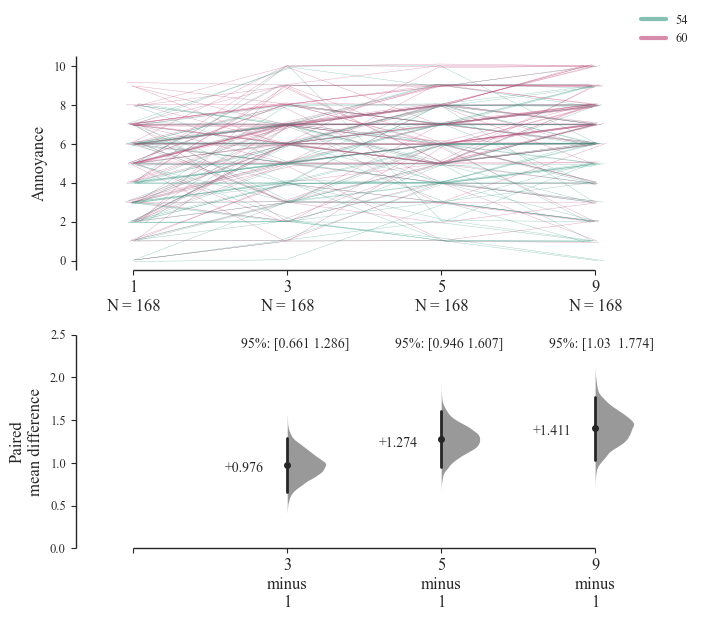

In [57]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                   contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                   slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette=mycolours[1:3], es_marker_size=4, contrast_ylim=(0, 2.5),
                                   legend_kwargs={'loc': 'lower center'}, ax=ax)

diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtBDabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtBDabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [58]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control test  control_N  test_N effect_size is_paired  difference  ci  \
0       1    3        168     168   Cohen's d  baseline    0.447704  95   
1       1    5        168     168   Cohen's d  baseline    0.589221  95   
2       1    9        168     168   Cohen's d  baseline    0.602227  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.302082  0.602362              0.0002     3.991841e-08   
1  0.435660  0.750909              0.0002     2.049133e-11   
2  0.437218  0.778378              0.0002     1.248546e-10   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              1996.5              1.219659e-08                    -5.994994  
1              1600.0              1.497806e-12                    -7.652331  
2              2095.5              1.546221e-11                    -7.241797

control test  control_N  test_N      effect_size   is_paired  difference  \
0       1    3        168     168  mean difference  sequential    0.976190   
1       3    5        168     168  mean difference  sequential    0.297619   
2       5    9        168     168  mean difference  sequential    0.136905   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.660714  1.285714            0.000200     3.991841e-08   
1  95  0.011905  0.547619            0.034793     1.094919e-02   
2  95 -0.101190  0.351190            0.218956     1.185307e-01   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              1996.5              1.219659e-08                    -5.994994  
1              2726.5              3.716497e-02                    -2.100746  
2              2741.5              2.422649e-01                    -1.173503

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


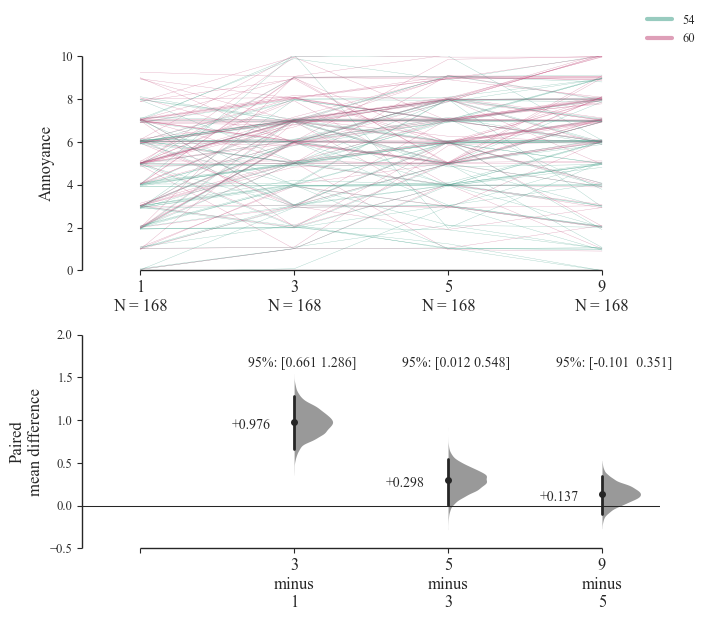

In [59]:
# calculate sequential paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataMD = dataloadSQ.mean_diff.plot(swarm_ylim=(0, 10), color_col='UASLAeq',
                                   contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.5},
                                   slopegraph_xjitter=0.0, slopegraph_yjitter=0.05, jitter_seed=303,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette=mycolours[1:3], es_marker_size=4, contrast_ylim=(-0.5, 2),
                                   legend_kwargs={'loc': 'lower center'}, ax=ax)

diffs = np.round(dataloadSQ.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtBDabestSeq.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtBDabestSeq.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataloadSQ.mean_diff.statistical_tests])

dataMD;
dataloadSQ.mean_diff.statistical_tests


In [60]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataloadSQ.cohens_d.statistical_tests])
dataloadSQ.cohens_d.statistical_tests


control test  control_N  test_N effect_size   is_paired  difference  ci  \
0       1    3        168     168   Cohen's d  sequential    0.447704  95   
1       3    5        168     168   Cohen's d  sequential    0.137169  95   
2       5    9        168     168   Cohen's d  sequential    0.058694  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.299316  0.599291            0.000200     3.991841e-08   
1  0.007897  0.259204            0.034793     1.094919e-02   
2 -0.038827  0.158758            0.218956     1.185307e-01   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0              1996.5              1.219659e-08                    -5.994994  
1              2726.5              3.716497e-02                    -2.100746  
2              2741.5              2.422649e-01                    -1.173503

#### Segregated by LAeq

##### 54 dB

control test  control_N  test_N      effect_size is_paired  difference  ci  \
0       1    3         84      84  mean difference  baseline    0.821429  95   
1       1    5         84      84  mean difference  baseline    1.166667  95   
2       1    9         84      84  mean difference  baseline    1.011905  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.416667  1.202381              0.0004         0.000180   
1  0.738095  1.595238              0.0002         0.000003   
2  0.535714  1.488095              0.0002         0.000159   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               489.5              1.313680e-04                    -4.011605  
1               401.5              9.939184e-07                    -5.285657  
2               603.5              1.031842e-04                    -4.079395

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


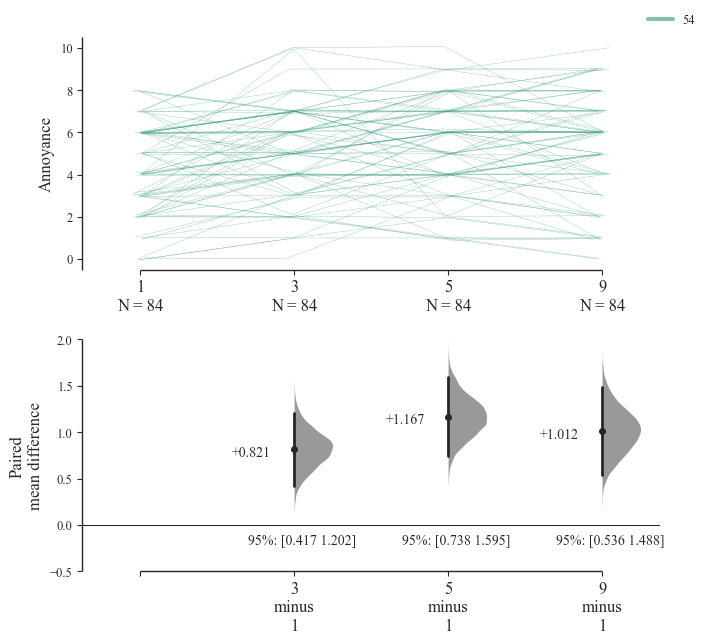

In [61]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataLoMD = dataLoloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                       contrast_show_es=True, es_sf=3,
                                       custom_palette=mycolours[1:], es_marker_size=4, contrast_ylim=(-0.5, 2),
                                       legend_kwargs={'loc': 'lower center'}, ax=ax)
diffs = np.round(dataLoloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-13.5, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB54DabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB54DabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataLoloadBL.mean_diff.statistical_tests])

dataLoMD;
dataLoloadBL.mean_diff.statistical_tests


In [62]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataLoloadBL.cohens_d.statistical_tests])
dataLoloadBL.cohens_d.statistical_tests


control test  control_N  test_N effect_size is_paired  difference  ci  \
0       1    3         84      84   Cohen's d  baseline    0.384312  95   
1       1    5         84      84   Cohen's d  baseline    0.542241  95   
2       1    9         84      84   Cohen's d  baseline    0.440618  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.197317  0.571956              0.0004         0.000180   
1  0.338718  0.758143              0.0002         0.000003   
2  0.235267  0.666787              0.0002         0.000159   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               489.5              1.313680e-04                    -4.011605  
1               401.5              9.939184e-07                    -5.285657  
2               603.5              1.031842e-04                    -4.079395

control test  control_N  test_N      effect_size   is_paired  difference  \
0       1    3         84      84  mean difference  sequential    0.821429   
1       3    5         84      84  mean difference  sequential    0.345238   
2       5    9         84      84  mean difference  sequential   -0.154762   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.416667  1.202381            0.000400         0.000180   
1  95 -0.083333  0.678571            0.090782         0.025336   
2  95 -0.511905  0.142857            0.392921         0.571022   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               489.5                  0.000131                    -4.011605  
1               640.0                  0.084735                    -1.744719  
2               730.5                  0.357431                     0.925420

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


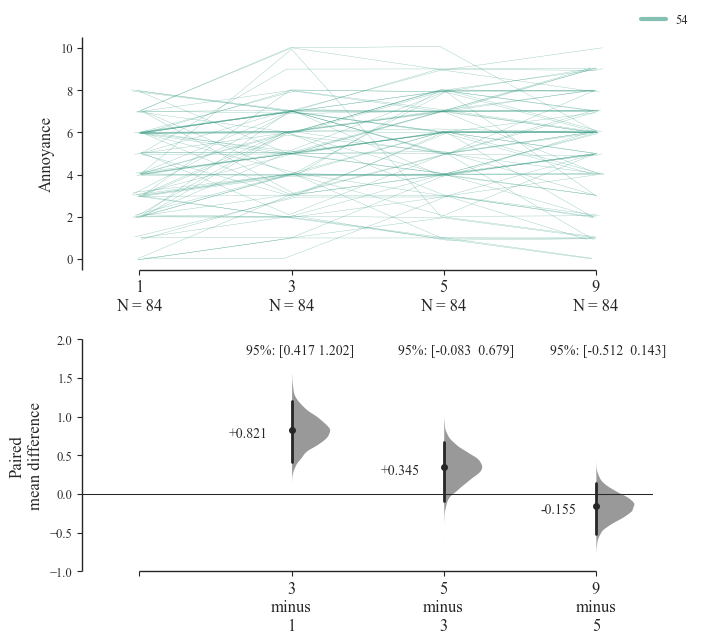

In [63]:
# calculate sequential paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataLoMD = dataLoloadSQ.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                       contrast_show_es=True, es_sf=3,
                                       custom_palette=mycolours[1:], es_marker_size=4, contrast_ylim=(-1, 2),
                                       legend_kwargs={'loc': 'lower center'}, ax=ax)

diffs = np.round(dataLoloadSQ.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB54DabestSeq.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB54DabestSeq.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataLoloadSQ.mean_diff.statistical_tests])

dataLoMD;
dataLoloadSQ.mean_diff.statistical_tests


In [64]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataLoloadSQ.cohens_d.statistical_tests])
dataLoloadSQ.cohens_d.statistical_tests


control test  control_N  test_N effect_size   is_paired  difference  ci  \
0       1    3         84      84   Cohen's d  sequential    0.384312  95   
1       3    5         84      84   Cohen's d  sequential    0.159297  95   
2       5    9         84      84   Cohen's d  sequential   -0.066582  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.199143  0.582215            0.000400         0.000180   
1 -0.036339  0.328584            0.090782         0.025336   
2 -0.216386  0.066528            0.392921         0.571022   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               489.5                  0.000131                    -4.011605  
1               640.0                  0.084735                    -1.744719  
2               730.5                  0.357431                     0.925420

##### 60 dB

control test  control_N  test_N      effect_size is_paired  difference  ci  \
0       1    3         84      84  mean difference  baseline    1.130952  95   
1       1    5         84      84  mean difference  baseline    1.380952  95   
2       1    9         84      84  mean difference  baseline    1.809524  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.619048  1.619048              0.0002     6.064807e-05   
1  0.904762  1.892857              0.0002     1.367945e-06   
2  1.214286  2.369048              0.0002     2.222515e-07   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               521.5              2.515423e-05                    -4.463727  
1               406.5              3.728534e-07                    -5.523432  
2               468.0              2.926737e-08                    -6.122818

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


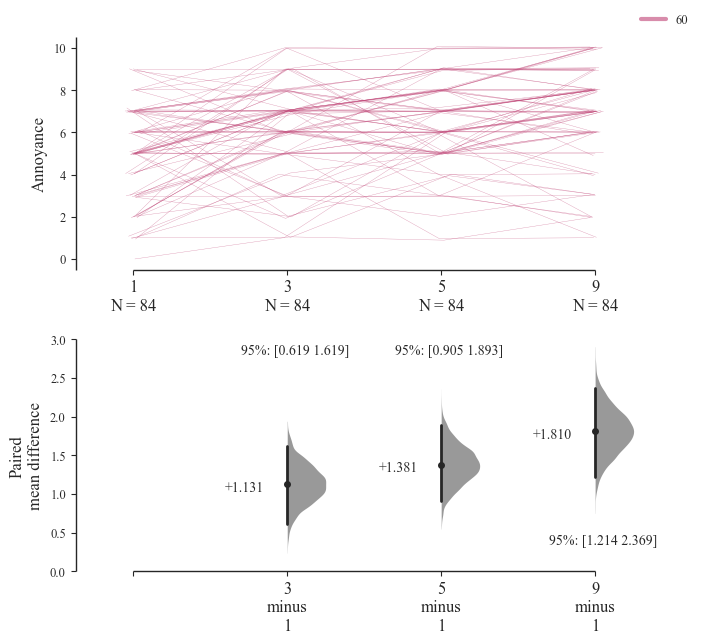

In [65]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataHiMD = dataHiloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                       contrast_show_es=True, es_sf=3,
                                       custom_palette=mycolours[2:], es_marker_size=4, contrast_ylim=(0, 3),
                                       legend_kwargs={'loc': 'lower center'}, ax=ax)

diffs = np.round(dataHiloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    if ii == 2:
        ax.text(x=0.7 + ii, y=-13.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    else:
        ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB60DabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB60DabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataHiloadBL.mean_diff.statistical_tests])

dataHiMD;
dataHiloadBL.mean_diff.statistical_tests


In [66]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataHiloadBL.cohens_d.statistical_tests])
dataHiloadBL.cohens_d.statistical_tests


control test  control_N  test_N effect_size is_paired  difference  ci  \
0       1    3         84      84   Cohen's d  baseline    0.530258  95   
1       1    5         84      84   Cohen's d  baseline    0.660162  95   
2       1    9         84      84   Cohen's d  baseline    0.810034  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.282318  0.785022              0.0002     6.064807e-05   
1  0.425015  0.911070              0.0002     1.367945e-06   
2  0.526487  1.102902              0.0002     2.222515e-07   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               521.5              2.515423e-05                    -4.463727  
1               406.5              3.728534e-07                    -5.523432  
2               468.0              2.926737e-08                    -6.122818

control test  control_N  test_N      effect_size   is_paired  difference  \
0       1    3         84      84  mean difference  sequential    1.130952   
1       3    5         84      84  mean difference  sequential    0.250000   
2       5    9         84      84  mean difference  sequential    0.428571   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.630952  1.595238            0.000200         0.000061   
1  95 -0.178571  0.630952            0.197960         0.158162   
2  95  0.107143  0.726190            0.010598         0.005573   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               521.5                  0.000025                    -4.463727  
1               727.5                  0.223543                    -1.226329  
2               508.0                  0.007861                    -2.724065

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


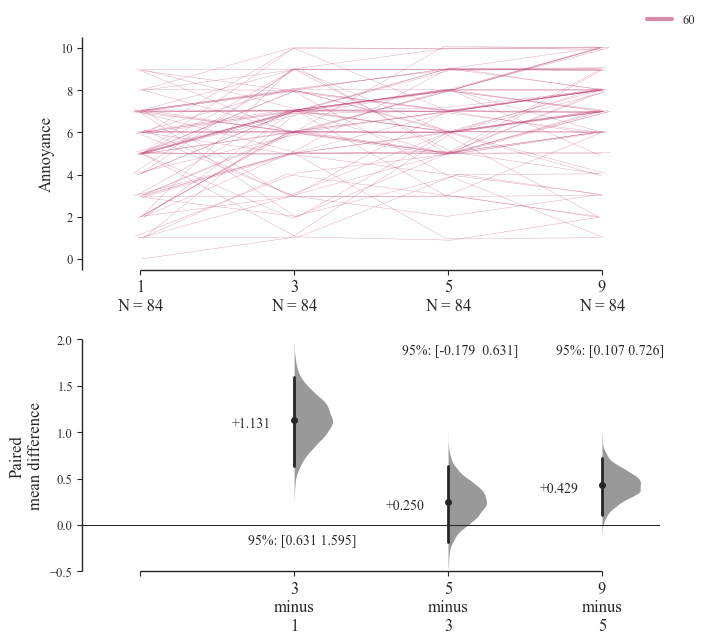

In [67]:
# calculate sequential paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataHiMD = dataHiloadSQ.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                       contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                       slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                       contrast_show_es=True, es_sf=3,
                                       custom_palette=mycolours[2:], es_marker_size=4, contrast_ylim=(-0.5, 2),
                                       legend_kwargs={'loc': 'lower center'}, ax=ax)


diffs = np.round(dataHiloadSQ.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    if ii == 0:
        ax.text(x=0.7 + ii, y=-13.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    else:
        ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB60DabestSeq.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB60DabestSeq.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataHiloadSQ.mean_diff.statistical_tests])

dataHiMD;
dataHiloadSQ.mean_diff.statistical_tests


In [68]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataHiloadSQ.cohens_d.statistical_tests])
dataHiloadSQ.cohens_d.statistical_tests


control test  control_N  test_N effect_size   is_paired  difference  ci  \
0       1    3         84      84   Cohen's d  sequential    0.530258  95   
1       3    5         84      84   Cohen's d  sequential    0.121538  95   
2       5    9         84      84   Cohen's d  sequential    0.198268  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.282600  0.772443            0.000200         0.000061   
1 -0.084457  0.316311            0.198160         0.158162   
2  0.050433  0.355630            0.010598         0.005573   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               521.5                  0.000025                    -4.463727  
1               727.5                  0.223543                    -1.226329  
2               508.0                  0.007861                    -2.724065

#### Segregated by UAS LAeq and type

##### 54 dB, H520

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N      effect_size is_paired  difference  ci  \
0       1    3         42      42  mean difference  baseline    0.619048  95   
1       1    5         42      42  mean difference  baseline    1.142857  95   
2       1    9         42      42  mean difference  baseline    1.142857  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.047619  1.095238            0.023795         0.019461   
1  0.476190  1.666667            0.000400         0.001198   
2  0.452381  1.833333            0.001400         0.002701   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               121.5                  0.027277                    -2.289389  
1               110.0                  0.000532                    -3.759369  
2               133.5                  0.002222                    -3.263776

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


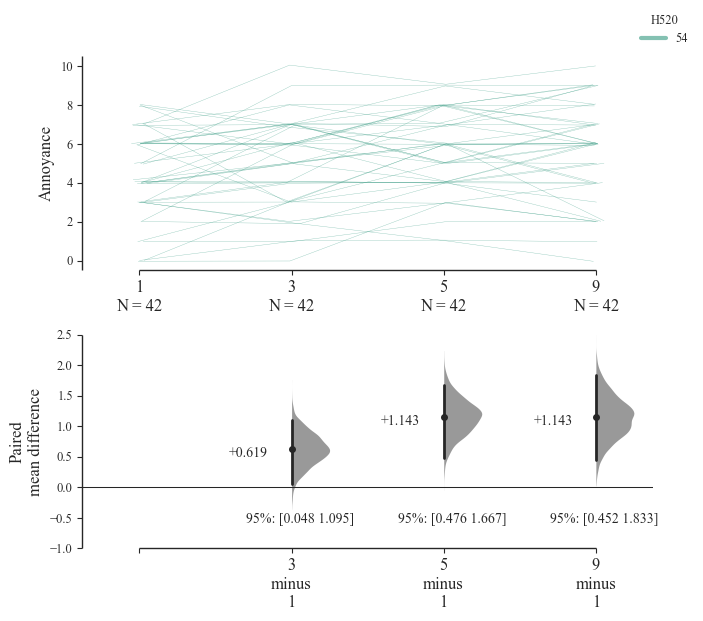

In [69]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataLoH520MD = dataLoH520loadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                               contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                               slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                               contrast_show_es=True, es_sf=3,
                                               custom_palette=mycolours[1:], es_marker_size=4, contrast_ylim=(-1, 2.5),
                                               legend_kwargs={'loc': 'lower center', 'title': "H520"}, ax=ax)
diffs = np.round(dataLoH520loadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-13.5, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB54H520DabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB54H520DabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataLoH520loadBL.mean_diff.statistical_tests])

dataLoH520MD;
dataLoH520loadBL.mean_diff.statistical_tests


In [70]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataLoH520loadBL.cohens_d.statistical_tests])
dataLoH520loadBL.cohens_d.statistical_tests


C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N effect_size is_paired  difference  ci  \
0       1    3         42      42   Cohen's d  baseline    0.275474  95   
1       1    5         42      42   Cohen's d  baseline    0.526491  95   
2       1    9         42      42   Cohen's d  baseline    0.488737  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.022761  0.517672            0.023795         0.019461   
1  0.227775  0.805118            0.000400         0.001198   
2  0.194019  0.802579            0.001400         0.002701   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               121.5                  0.027277                    -2.289389  
1               110.0                  0.000532                    -3.759369  
2               133.5                  0.002222                    -3.263776

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N      effect_size   is_paired  difference  \
0       1    3         42      42  mean difference  sequential    0.619048   
1       3    5         42      42  mean difference  sequential    0.523810   
2       5    9         42      42  mean difference  sequential    0.000000   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.047619  1.095238            0.023795         0.019461   
1  95  0.047619  0.952381            0.022795         0.033926   
2  95 -0.428571  0.380952            0.912418         0.890156   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               121.5                  0.027277                    -2.289389  
1               142.0                  0.030835                    -2.236293  
2               226.0                  1.000000                     0.000000

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


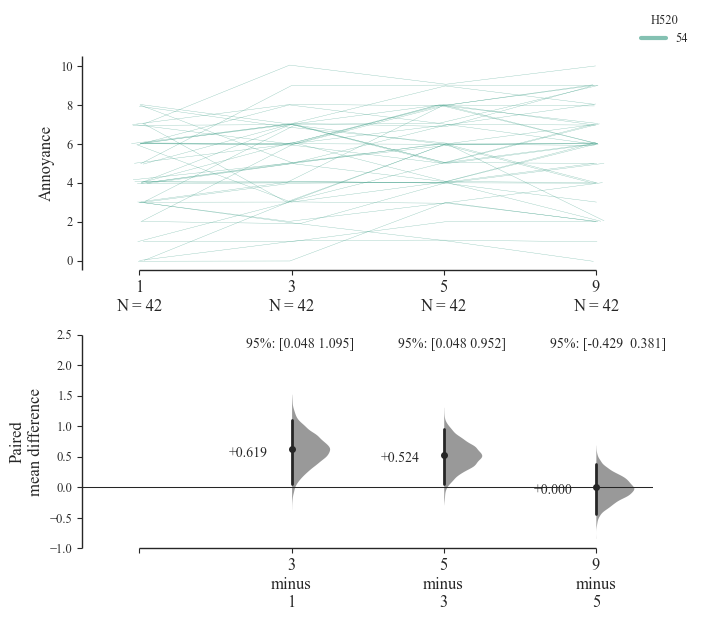

In [71]:
# calculate sequential paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataLoH520MD = dataLoH520loadSQ.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                               contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                               slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                               contrast_show_es=True, es_sf=3,
                                               custom_palette=mycolours[1:], es_marker_size=4, contrast_ylim=(-1, 2.5),
                                               legend_kwargs={'loc': 'lower center', 'title': "H520"}, ax=ax)

diffs = np.round(dataLoH520loadSQ.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB54H520DabestSeq.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB54H520DabestSeq.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataLoH520loadSQ.mean_diff.statistical_tests])

dataLoH520MD;
dataLoH520loadSQ.mean_diff.statistical_tests


In [72]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataLoH520loadSQ.cohens_d.statistical_tests])
dataLoH520loadSQ.cohens_d.statistical_tests


C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N effect_size   is_paired  difference  ci  \
0       1    3         42      42   Cohen's d  sequential    0.275474  95   
1       3    5         42      42   Cohen's d  sequential    0.238503  95   
2       5    9         42      42   Cohen's d  sequential    0.000000  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.032248  0.516894            0.023795         0.019461   
1  0.029578  0.457933            0.022795         0.033926   
2 -0.192840  0.174945            0.912418         0.890156   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               121.5                  0.027277                    -2.289389  
1               142.0                  0.030835                    -2.236293  
2               226.0                  1.000000                     0.000000

##### 60 dB, H520

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N      effect_size is_paired  difference  ci  \
0       1    3         42      42  mean difference  baseline    1.023810  95   
1       1    5         42      42  mean difference  baseline    1.333333  95   
2       1    9         42      42  mean difference  baseline    1.880952  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.333333  1.690476            0.008598         0.010268   
1  0.666667  2.071429            0.000400         0.000838   
2  1.119048  2.714286            0.000200         0.000081   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               148.5                  0.006226                    -2.884229  
1               132.5                  0.000570                    -3.735967  
2                92.0                  0.000033                    -4.661242

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


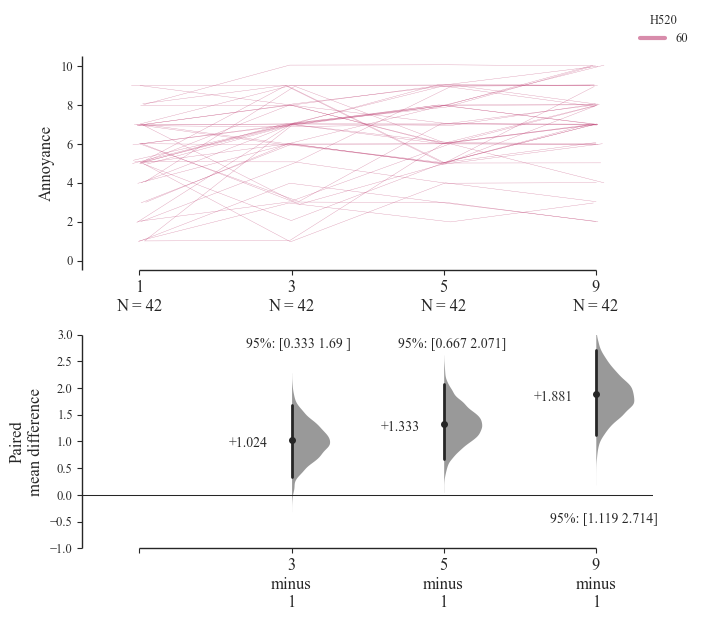

In [73]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataHiH520MD = dataHiH520loadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                               contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                               slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                               contrast_show_es=True, es_sf=3,
                                               custom_palette=mycolours[2:], es_marker_size=4, contrast_ylim=(-1, 3),
                                               legend_kwargs={'loc': 'lower center', 'title': "H520"}, ax=ax)

diffs = np.round(dataHiH520loadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    if ii == 2:
        ax.text(x=0.7 + ii, y=-13.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    else:
        ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB60H520DabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB60H520DabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataHiH520loadBL.mean_diff.statistical_tests])

dataHiH520MD;
dataHiH520loadBL.mean_diff.statistical_tests


In [74]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataHiH520loadBL.cohens_d.statistical_tests])
dataHiH520loadBL.cohens_d.statistical_tests


C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N effect_size is_paired  difference  ci  \
0       1    3         42      42   Cohen's d  baseline    0.458114  95   
1       1    5         42      42   Cohen's d  baseline    0.644498  95   
2       1    9         42      42   Cohen's d  baseline    0.870035  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.137607  0.810300            0.008798         0.010268   
1  0.329352  1.016513            0.000400         0.000838   
2  0.498519  1.322483            0.000200         0.000081   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               148.5                  0.006226                    -2.884229  
1               132.5                  0.000570                    -3.735967  
2                92.0                  0.000033                    -4.661242

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N      effect_size   is_paired  difference  \
0       1    3         42      42  mean difference  sequential    1.023810   
1       3    5         42      42  mean difference  sequential    0.309524   
2       5    9         42      42  mean difference  sequential    0.547619   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.285714  1.666667            0.008598         0.010268   
1  95 -0.309524  0.880952            0.283743         0.315645   
2  95  0.166667  0.928571            0.005199         0.007245   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               148.5                  0.006226                    -2.884229  
1               225.5                  0.320260                    -1.006117  
2                80.5                  0.007146                    -2.831628

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


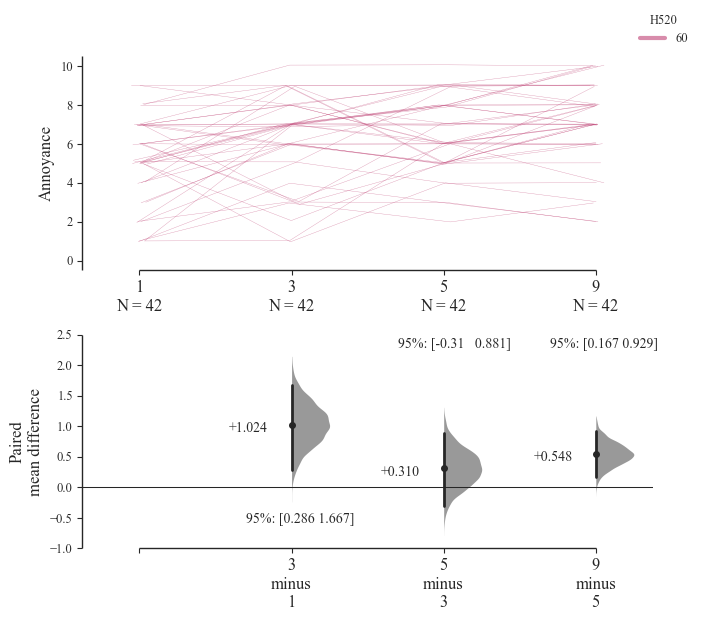

In [75]:
# calculate sequential paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataHiH520MD = dataHiH520loadSQ.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                               contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                               slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                               contrast_show_es=True, es_sf=3,
                                               custom_palette=mycolours[2:], es_marker_size=4, contrast_ylim=(-1, 2.5),
                                               legend_kwargs={'loc': 'lower center', 'title': "H520"}, ax=ax)


diffs = np.round(dataHiH520loadSQ.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    if ii == 0:
        ax.text(x=0.7 + ii, y=-13.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    else:
        ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB60H520DabestSeq.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB60H520DabestSeq.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataHiH520loadSQ.mean_diff.statistical_tests])

dataHiH520MD;
dataHiH520loadSQ.mean_diff.statistical_tests


In [76]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataHiH520loadSQ.cohens_d.statistical_tests])
dataHiH520loadSQ.cohens_d.statistical_tests


C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N effect_size   is_paired  difference  ci  \
0       1    3         42      42   Cohen's d  sequential    0.458114  95   
1       3    5         42      42   Cohen's d  sequential    0.147816  95   
2       5    9         42      42   Cohen's d  sequential    0.271639  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.119275  0.794117            0.008798         0.010268   
1 -0.148997  0.419511            0.283743         0.315645   
2  0.075423  0.509602            0.005199         0.007245   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               148.5                  0.006226                    -2.884229  
1               225.5                  0.320260                    -1.006117  
2                80.5                  0.007146                    -2.831628

##### 54 dB, T150

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N      effect_size is_paired  difference  ci  \
0       1    3         42      42  mean difference  baseline    1.023810  95   
1       1    5         42      42  mean difference  baseline    1.190476  95   
2       1    9         42      42  mean difference  baseline    0.880952  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.428571  1.595238            0.003199         0.003138   
1  0.571429  1.809524            0.001000         0.000879   
2  0.214286  1.571429            0.023995         0.021395   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               127.0                  0.001855                    -3.327926  
1                96.0                  0.000678                    -3.677285  
2               176.0                  0.017125                    -2.485053

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


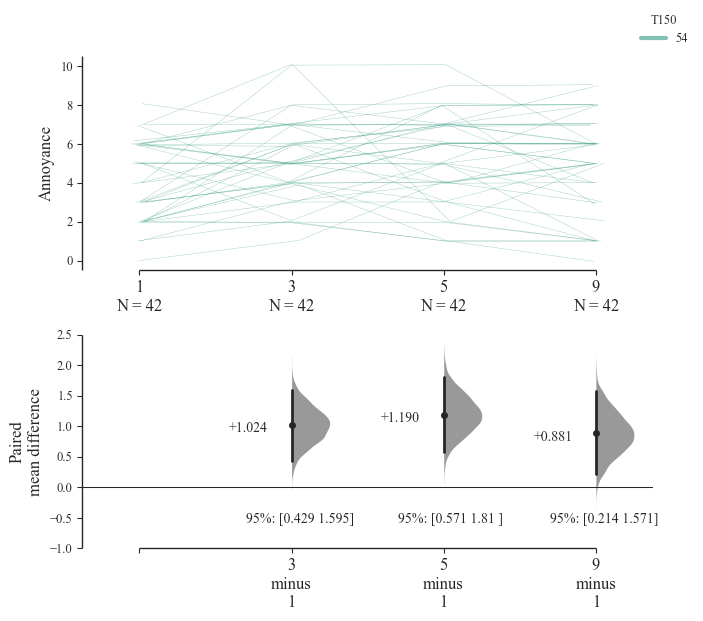

In [77]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataLoT150MD = dataLoT150loadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                               contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                               slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                               contrast_show_es=True, es_sf=3,
                                               custom_palette=mycolours[1:], es_marker_size=4, contrast_ylim=(-1, 2.5),
                                               legend_kwargs={'loc': 'lower center', 'title': "T150"}, ax=ax)
diffs = np.round(dataLoT150loadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-13.5, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB54T150DabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB54T150DabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataLoT150loadBL.mean_diff.statistical_tests])

dataLoT150MD;
dataLoT150loadBL.mean_diff.statistical_tests


In [78]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataLoT150loadBL.cohens_d.statistical_tests])
dataLoT150loadBL.cohens_d.statistical_tests


C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N effect_size is_paired  difference  ci  \
0       1    3         42      42   Cohen's d  baseline    0.501650  95   
1       1    5         42      42   Cohen's d  baseline    0.554929  95   
2       1    9         42      42   Cohen's d  baseline    0.390932  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.207878  0.801848            0.003199         0.003138   
1  0.261057  0.888043            0.000400         0.000879   
2  0.093678  0.726491            0.023995         0.021395   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               127.0                  0.001855                    -3.327926  
1                96.0                  0.000678                    -3.677285  
2               176.0                  0.017125                    -2.485053

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N      effect_size   is_paired  difference  \
0       1    3         42      42  mean difference  sequential    1.023810   
1       3    5         42      42  mean difference  sequential    0.166667   
2       5    9         42      42  mean difference  sequential   -0.309524   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.428571  1.619048            0.003199         0.003138   
1  95 -0.571429  0.666667            0.568886         0.285736   
2  95 -0.857143  0.119048            0.202360         0.329206   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               127.0                  0.001855                    -3.327926  
1               181.5                  0.604774                    -0.521573  
2               138.0                  0.237850                     1.197862

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


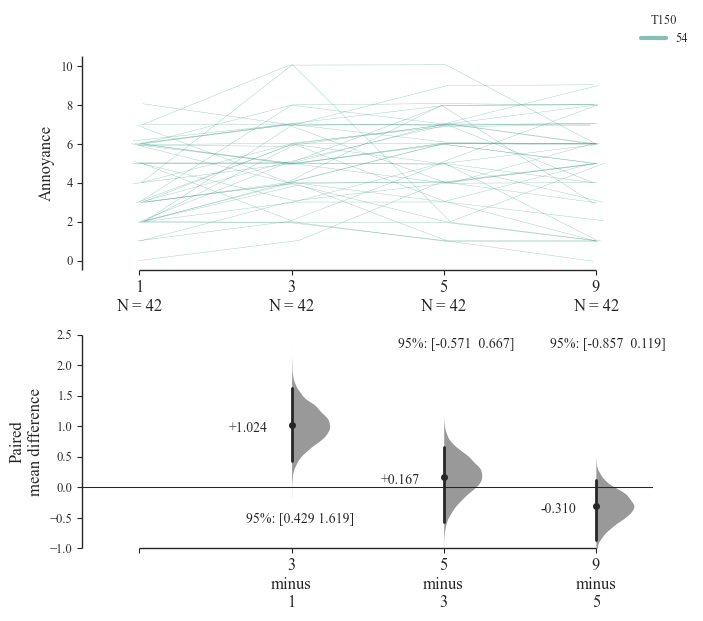

In [79]:
# calculate sequential paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataLoT150MD = dataLoT150loadSQ.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                               contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                               slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                               contrast_show_es=True, es_sf=3,
                                               custom_palette=mycolours[1:], es_marker_size=4, contrast_ylim=(-1, 2.5),
                                               legend_kwargs={'loc': 'lower center', 'title': "T150"}, ax=ax)

diffs = np.round(dataLoT150loadSQ.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    if ii == 0:
        ax.text(x=0.7 + ii, y=-13.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    else:
        ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB54T150DabestSeq.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB54T150DabestSeq.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataLoT150loadSQ.mean_diff.statistical_tests])
dataLoT150MD;
dataLoT150loadSQ.mean_diff.statistical_tests


In [80]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataLoT150loadSQ.cohens_d.statistical_tests])
dataLoT150loadSQ.cohens_d.statistical_tests


C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N effect_size   is_paired  difference  ci  \
0       1    3         42      42   Cohen's d  sequential    0.501650  95   
1       3    5         42      42   Cohen's d  sequential    0.077207  95   
2       5    9         42      42   Cohen's d  sequential   -0.131116  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.217694  0.806379            0.003199         0.003138   
1 -0.246645  0.337045            0.568886         0.285736   
2 -0.355194  0.065223            0.202360         0.329206   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               127.0                  0.001855                    -3.327926  
1               181.5                  0.604774                    -0.521573  
2               138.0                  0.237850                     1.197862

##### 60 dB, T150

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N      effect_size is_paired  difference  ci  \
0       1    3         42      42  mean difference  baseline    1.238095  95   
1       1    5         42      42  mean difference  baseline    1.428571  95   
2       1    9         42      42  mean difference  baseline    1.738095  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.500000  1.904762              0.0012         0.002227   
1  0.738095  2.119048              0.0014         0.000574   
2  0.833333  2.523810              0.0006         0.000785   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               120.0                  0.001554                    -3.390523  
1                81.0                  0.000235                    -4.030924  
2               150.5                  0.000273                    -3.981754

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


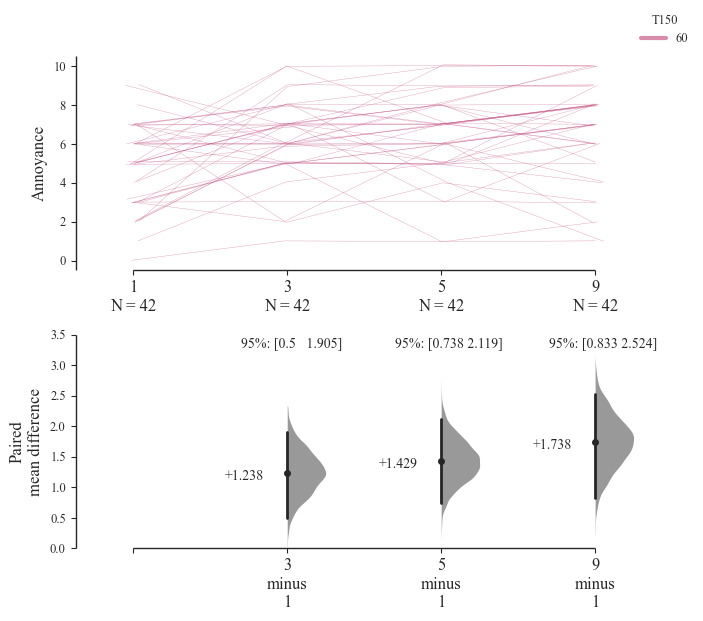

In [81]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataHiT150MD = dataHiT150loadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                               contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                               slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                               contrast_show_es=True, es_sf=3,
                                               custom_palette=mycolours[2:], es_marker_size=4, contrast_ylim=(0, 3.5),
                                               legend_kwargs={'loc': 'lower center', 'title': "T150"}, ax=ax)

diffs = np.round(dataHiT150loadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB60T150DabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB60T150DabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataHiT150loadBL.mean_diff.statistical_tests])

dataHiT150MD;
dataHiT150loadBL.mean_diff.statistical_tests


In [82]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataHiT150loadBL.cohens_d.statistical_tests])
dataHiT150loadBL.cohens_d.statistical_tests


C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N effect_size is_paired  difference  ci  \
0       1    3         42      42   Cohen's d  baseline    0.604145  95   
1       1    5         42      42   Cohen's d  baseline    0.669089  95   
2       1    9         42      42   Cohen's d  baseline    0.749583  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.230064  0.982229              0.0012         0.002227   
1  0.343386  1.031713              0.0014         0.000574   
2  0.336678  1.172901              0.0006         0.000785   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               120.0                  0.001554                    -3.390523  
1                81.0                  0.000235                    -4.030924  
2               150.5                  0.000273                    -3.981754

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N      effect_size   is_paired  difference  \
0       1    3         42      42  mean difference  sequential    1.238095   
1       3    5         42      42  mean difference  sequential    0.190476   
2       5    9         42      42  mean difference  sequential    0.309524   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  95  0.500000  1.904762            0.001200         0.002227   
1  95 -0.380952  0.666667            0.540292         0.307765   
2  95 -0.214286  0.761905            0.186763         0.173164   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               120.0                  0.001554                    -3.390523  
1               147.5                  0.486131                    -0.702834  
2               180.5                  0.221351                    -1.241844

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


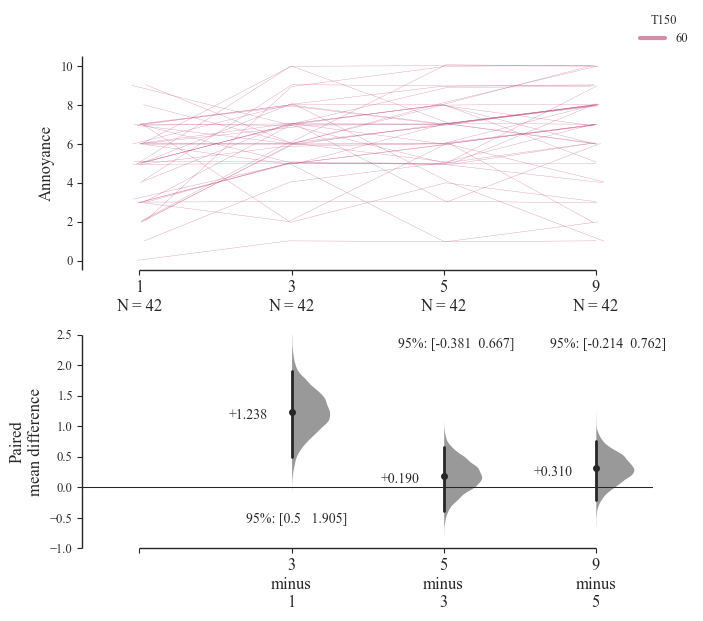

In [83]:
# calculate sequential paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataHiT150MD = dataHiT150loadSQ.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASLAeq',
                                               contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.6},
                                               slopegraph_xjitter=0.02, slopegraph_yjitter=0.03, jitter_seed=303,
                                               contrast_show_es=True, es_sf=3,
                                               custom_palette=mycolours[2:], es_marker_size=4, contrast_ylim=(-1, 2.5),
                                               legend_kwargs={'loc': 'lower center', 'title': "T150"}, ax=ax)


diffs = np.round(dataHiT150loadSQ.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    if ii == 0:
        ax.text(x=0.7 + ii, y=-13.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    else:
        ax.text(x=0.7 + ii, y=-4.5, s="95%: " + str(diffrow[1:]), fontsize=10)
    
if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB60T150DabestSeq.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB60T150DabestSeq.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataHiT150loadSQ.mean_diff.statistical_tests])

dataHiT150MD;
dataHiT150loadSQ.mean_diff.statistical_tests


In [84]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataHiT150loadSQ.cohens_d.statistical_tests])
dataHiT150loadSQ.cohens_d.statistical_tests


C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


control test  control_N  test_N effect_size   is_paired  difference  ci  \
0       1    3         42      42   Cohen's d  sequential    0.604145  95   
1       3    5         42      42   Cohen's d  sequential    0.093217  95   
2       5    9         42      42   Cohen's d  sequential    0.133791  95   

    bca_low  bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  0.219027  0.962721            0.001200         0.002227   
1 -0.179928  0.352837            0.540292         0.307765   
2 -0.081875  0.366395            0.186763         0.173164   

   statistic_wilcoxon  pvalue_paired_students_t  statistic_paired_students_t  
0               120.0                  0.001554                    -3.390523  
1               147.5                  0.486131                    -0.702834  
2               180.5                  0.221351                    -1.241844

### AAM attitude

In [85]:
# select subset of data for analysis and sort
data = dataBySubjTestB
data = data[data['UASLAeq'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'UASLAeq', 'AAM_attitude', 'Annoyance']]

# separate by level
dataLo = data.loc[data['UASLAeq'] == "54", :]
dataHi = data.loc[data['UASLAeq'] == "60", :]


In [86]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=['Supportive', 'Ambivalent', 'Concerned', 'Neutral'],
                         x='AAM_attitude', y='Annoyance', resamples=5000, random_seed=24624)

dataLoloadBL = dabest.load(data=dataLo, idx=['Supportive', 'Ambivalent', 'Concerned', 'Neutral'],
                           x='AAM_attitude', y='Annoyance', resamples=5000, random_seed=8478)

dataHiloadBL = dabest.load(data=dataHi, idx=['Supportive', 'Ambivalent', 'Concerned', 'Neutral'],
                           x='AAM_attitude', y='Annoyance', resamples=5000, random_seed=13)


control        test  control_N  test_N      effect_size is_paired  \
0  Supportive  Ambivalent        176     144  mean difference      None   
1  Supportive   Concerned        176     112  mean difference      None   
2  Supportive     Neutral        176     240  mean difference      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0    1.591540  95  1.145202  2.049242            0.000200  3.743899e-11   
1    0.780032  95  0.200487  1.386364            0.010798  1.050531e-02   
2    1.394318  95  0.933712  1.842424            0.000200  5.657951e-09   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0        -6.860482       1.532014e-10             -6.619582   
1        -2.579852       9.810589e-03             -2.599856   
2        -5.973261       2.956642e-09             -6.066222   

   pvalue_mann_whitney  statistic_mann_whitney  
0         4.089515e-09                  7875.5  
1         1.675580e-02                  8220.0  
2         2.187909e-08                 14390.5

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


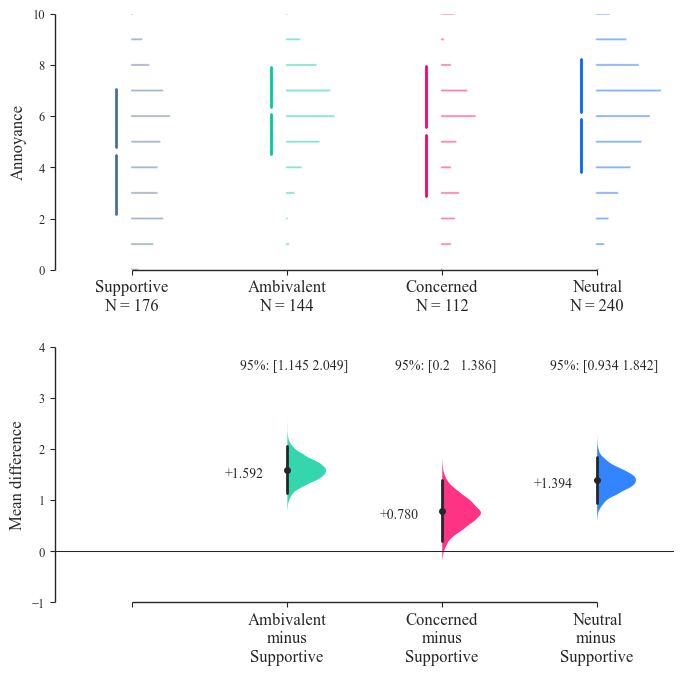

In [87]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                   raw_marker_size=0.1,
                                   swarmplot_kwargs={'alpha': 0.3},
                                   contrast_show_deltas=False,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette={'Neutral': mycolours[0],
                                                   'Ambivalent': mycolours[1],
                                                   'Concerned': mycolours[2],
                                                   'Supportive': mycolours[3]},
                                   swarm_desat=1,
                                   halfviolin_desat=1,
                                   bar_desat=1,
                                   es_marker_size=4,
                                   contrast_ylim=(-1, 4),
                                   ax=ax,
                                   )

diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-3.9, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtBAttDabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtBAttDabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [88]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control        test  control_N  test_N effect_size is_paired  \
0  Supportive  Ambivalent        176     144   Cohen's d      None   
1  Supportive   Concerned        176     112   Cohen's d      None   
2  Supportive     Neutral        176     240   Cohen's d      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0    0.743820  95  0.528476  0.960925            0.000200  3.743899e-11   
1    0.314254  95  0.077253  0.555377            0.010798  1.050531e-02   
2    0.602009  95  0.396274  0.809763            0.000200  5.657951e-09   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0        -6.860482       1.532014e-10             -6.619582   
1        -2.579852       9.810589e-03             -2.599856   
2        -5.973261       2.956642e-09             -6.066222   

   pvalue_mann_whitney  statistic_mann_whitney  
0         4.089515e-09                  7875.5  
1         1.675580e-02                  8220.0  
2         2.187909e-08                 14390.5

control        test  control_N  test_N      effect_size is_paired  \
0  Supportive  Ambivalent         88      72  mean difference      None   
1  Supportive   Concerned         88      56  mean difference      None   
2  Supportive     Neutral         88     120  mean difference      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0    1.608586  95  0.981061  2.236111            0.000200  1.142550e-06   
1    0.850649  95  0.076299  1.694805            0.034993  4.239826e-02   
2    1.603030  95  1.015152  2.237121            0.000200  9.265112e-07   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0        -5.064073       2.207513e-06             -4.914543   
1        -2.053312       3.858165e-02             -2.088023   
2        -5.082967       6.422447e-07             -5.138140   

   pvalue_mann_whitney  statistic_mann_whitney  
0             0.000010                  1892.0  
1             0.075897                  2034.0  
2             0.000002                  3265.0

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


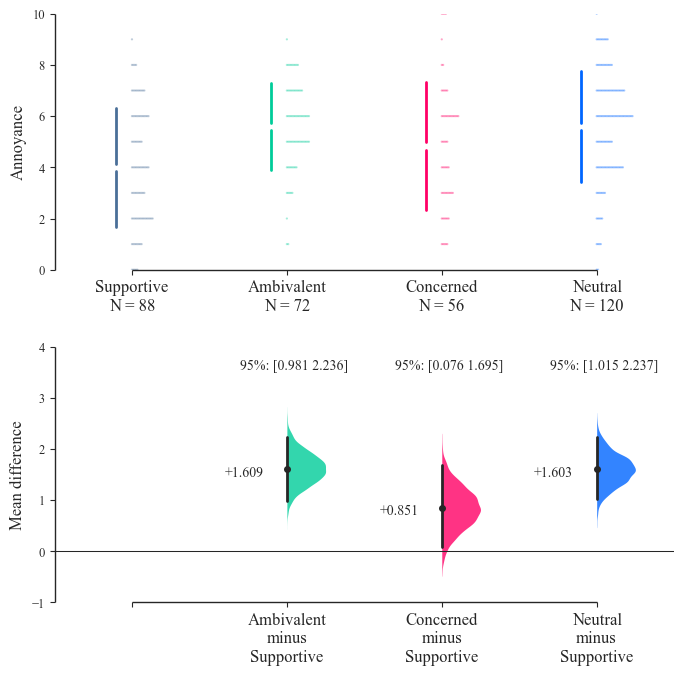

In [89]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataLoMD = dataLoloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                       raw_marker_size=0.1,
                                       swarmplot_kwargs={'alpha': 0.3},
                                       contrast_show_deltas=False,
                                       contrast_show_es=True, es_sf=3,
                                       custom_palette={'Neutral': mycolours[0],
                                                       'Ambivalent': mycolours[1],
                                                       'Concerned': mycolours[2],
                                                       'Supportive': mycolours[3]},
                                       swarm_desat=1,
                                       halfviolin_desat=1,
                                       bar_desat=1,
                                       es_marker_size=4,
                                       contrast_ylim=(-1, 4),
                                       ax=ax,
                                       )

diffs = np.round(dataLoloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-3.9, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB54AttDabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB54AttDabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataLoloadBL.mean_diff.statistical_tests])

dataLoMD;
dataLoloadBL.mean_diff.statistical_tests


In [90]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataLoloadBL.cohens_d.statistical_tests])
dataLoloadBL.cohens_d.statistical_tests


control        test  control_N  test_N effect_size is_paired  \
0  Supportive  Ambivalent         88      72   Cohen's d      None   
1  Supportive   Concerned         88      56   Cohen's d      None   
2  Supportive     Neutral         88     120   Cohen's d      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0    0.780972  95  0.460140  1.105184            0.000200  1.142550e-06   
1    0.356928  95  0.021573  0.707557            0.034993  4.239826e-02   
2    0.721117  95  0.436160  1.032087            0.000200  9.265112e-07   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0        -5.064073       2.207513e-06             -4.914543   
1        -2.053312       3.858165e-02             -2.088023   
2        -5.082967       6.422447e-07             -5.138140   

   pvalue_mann_whitney  statistic_mann_whitney  
0             0.000010                  1892.0  
1             0.075897                  2034.0  
2             0.000002                  3265.0

control        test  control_N  test_N      effect_size is_paired  \
0  Supportive  Ambivalent         88      72  mean difference      None   
1  Supportive   Concerned         88      56  mean difference      None   
2  Supportive     Neutral         88     120  mean difference      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0    1.574495  95  0.968434  2.154040            0.000200      0.000001   
1    0.709416  95 -0.108766  1.514610            0.095181      0.093127   
2    1.185606  95  0.553030  1.810606            0.000800      0.000378   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0        -5.102123           0.000003             -4.859700   
1        -1.693097           0.091355             -1.699815   
2        -3.624742           0.000297             -3.680528   

   pvalue_mann_whitney  statistic_mann_whitney  
0             0.000028                  1960.5  
1             0.091117                  2055.0  
2             0.000699                  3838.5

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


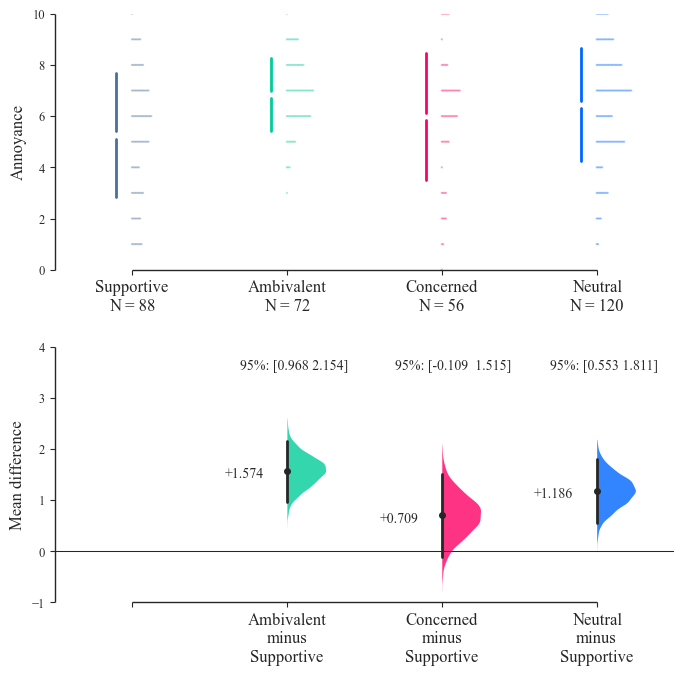

In [91]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataHiMD = dataHiloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                       raw_marker_size=0.1,
                                       swarmplot_kwargs={'alpha': 0.3},
                                       contrast_show_deltas=False,
                                       contrast_show_es=True, es_sf=3,
                                       custom_palette={'Neutral': mycolours[0],
                                                       'Ambivalent': mycolours[1],
                                                       'Concerned': mycolours[2],
                                                       'Supportive': mycolours[3]},
                                       swarm_desat=1,
                                       halfviolin_desat=1,
                                       bar_desat=1,
                                       es_marker_size=4,
                                       contrast_ylim=(-1, 4),
                                       ax=ax,
                                       )

diffs = np.round(dataHiloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-3.9, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtB60AttDabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtB60AttDabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataHiloadBL.mean_diff.statistical_tests])

dataHiMD;
dataHiloadBL.mean_diff.statistical_tests


In [92]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataHiloadBL.cohens_d.statistical_tests])
dataHiloadBL.cohens_d.statistical_tests


control        test  control_N  test_N effect_size is_paired  \
0  Supportive  Ambivalent         88      72   Cohen's d      None   
1  Supportive   Concerned         88      56   Cohen's d      None   
2  Supportive     Neutral         88     120   Cohen's d      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0    0.772257  95  0.463509  1.062489            0.000200      0.000001   
1    0.290568  95 -0.055265  0.629421            0.095381      0.093127   
2    0.516547  95  0.232302  0.794749            0.000800      0.000378   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0        -5.102123           0.000003             -4.859700   
1        -1.693097           0.091355             -1.699815   
2        -3.624742           0.000297             -3.680528   

   pvalue_mann_whitney  statistic_mann_whitney  
0             0.000028                  1960.5  
1             0.091117                  2055.0  
2             0.000699                  3838.5

### Home residence area

In [93]:
# select subset of data for analysis and sort
data = dataBySubjTestB
data = data[data['UASLAeq'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'UASLAeq', 'Home_Area', 'Annoyance']]


In [94]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=['Urban', 'Suburban', 'Rural'],
                         x='Home_Area', y='Annoyance', resamples=5000, random_seed=24624)


control      test  control_N  test_N      effect_size is_paired  difference  \
0   Urban  Suburban        432     224  mean difference      None    1.161872   
1   Urban     Rural        432      16  mean difference      None    2.407407   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0  95  0.818452  1.499504              0.0002  1.262030e-11        -6.911108   
1  95  1.678241  3.053241              0.0004  2.360354e-06        -6.666549   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0       6.802420e-10             -6.263983         1.818505e-08   
1       1.152023e-04             -3.890693         6.250463e-05   

   statistic_mann_whitney  
0                 35546.5  
1                  1434.0

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


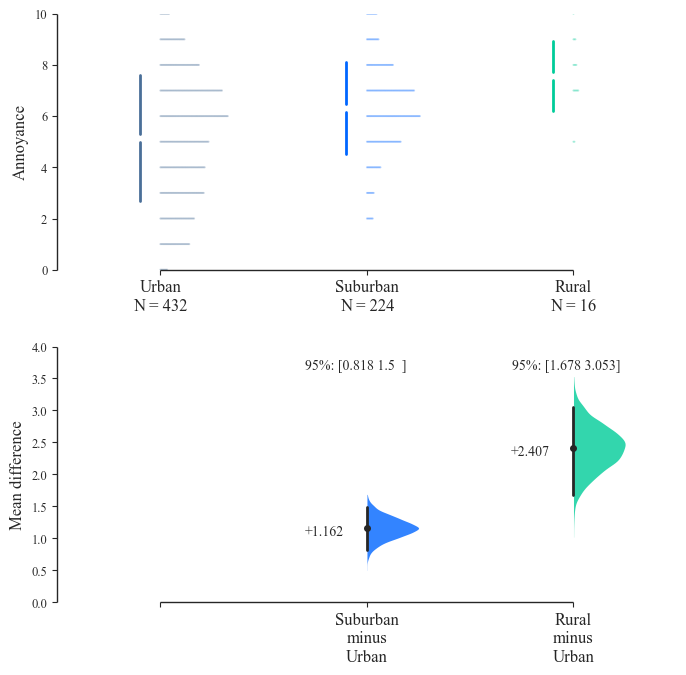

In [95]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                   raw_marker_size=0.05,
                                   swarmplot_kwargs={'alpha': 0.3},
                                   contrast_show_deltas=False,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette={'Suburban': mycolours[0],
                                                   'Rural': mycolours[1],
                                                   'Urban': mycolours[3]},
                                   swarm_desat=1,
                                   halfviolin_desat=1,
                                   bar_desat=1,
                                   es_marker_size=4,
                                   contrast_ylim=(0, 4),
                                   ax=ax,
                                   )

diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-3.9, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtBAORDabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtBAORDabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [96]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control      test  control_N  test_N effect_size is_paired  difference  ci  \
0   Urban  Suburban        432     224   Cohen's d      None    0.515747  95   
1   Urban     Rural        432      16   Cohen's d      None    0.990522  95   

    bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0  0.361976  0.664886              0.0002  1.262030e-11        -6.911108   
1  0.688414  1.260290              0.0004  2.360354e-06        -6.666549   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0       6.802420e-10             -6.263983         1.818505e-08   
1       1.152023e-04             -3.890693         6.250463e-05   

   statistic_mann_whitney  
0                 35546.5  
1                  1434.0

## Parts A and B combined

### AAM attitude

In [97]:
# select subset of data for analysis and sort
data = dataBySubjTest
data = data[data['UASLAeq'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'AAM_attitude', 'Annoyance']]


In [98]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=['Supportive', 'Ambivalent', 'Concerned', 'Neutral'],
                         x='AAM_attitude', y='Annoyance', resamples=5000, random_seed=3487)


control        test  control_N  test_N      effect_size is_paired  \
0  Supportive  Ambivalent       1034     768  mean difference      None   
1  Supportive   Concerned       1034     658  mean difference      None   
2  Supportive     Neutral       1034    1410  mean difference      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0    0.795261  95  0.570663  1.024266              0.0002  8.029949e-12   
1    0.657917  95  0.414341  0.898176              0.0002  7.900013e-08   
2    1.339781  95  1.131077  1.542360              0.0002  6.911693e-36   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0        -6.884668       2.165023e-11             -6.737269   
1        -5.395853       1.695260e-07             -5.251998   
2       -12.737735       1.431297e-36            -12.841101   

   pvalue_mann_whitney  statistic_mann_whitney  
0         6.909585e-11                326288.0  
1         3.037012e-07                290326.5  
2         2.165400e-32                525950.5

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


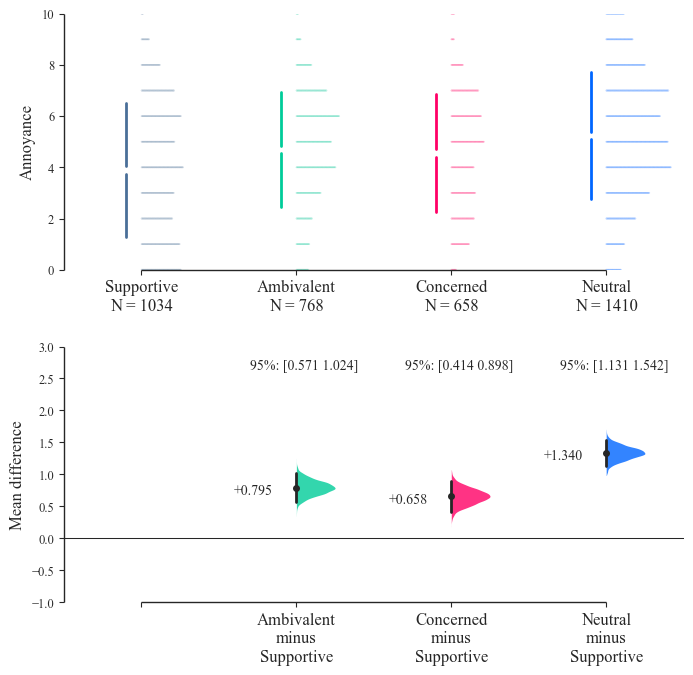

In [99]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                   raw_marker_size=0.005,
                                   swarmplot_kwargs={'alpha': 0.3},
                                   contrast_show_deltas=False,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette={'Neutral': mycolours[0],
                                                   'Ambivalent': mycolours[1],
                                                   'Concerned': mycolours[2],
                                                   'Supportive': mycolours[3]},
                                   swarm_desat=1,
                                   halfviolin_desat=1,
                                   bar_desat=1,
                                   es_marker_size=4,
                                   contrast_ylim=(-1, 3),
                                   ax=ax,
                                   )

diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-3.9, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtsABAttDabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtsABAttDabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [100]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control        test  control_N  test_N effect_size is_paired  \
0  Supportive  Ambivalent       1034     768   Cohen's d      None   
1  Supportive   Concerned       1034     658   Cohen's d      None   
2  Supportive     Neutral       1034    1410   Cohen's d      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0    0.320937  95  0.230381  0.416237              0.0002  8.029949e-12   
1    0.261910  95  0.163607  0.359320              0.0002  7.900013e-08   
2    0.525755  95  0.441927  0.607587              0.0002  6.911693e-36   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0        -6.884668       2.165023e-11             -6.737269   
1        -5.395853       1.695260e-07             -5.251998   
2       -12.737735       1.431297e-36            -12.841101   

   pvalue_mann_whitney  statistic_mann_whitney  
0         6.909585e-11                326288.0  
1         3.037012e-07                290326.5  
2         2.165400e-32                525950.5

### Home residence area

In [101]:
# select subset of data for analysis and sort
data = dataBySubjTest
data = data[data['UASLAeq'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'UASLAeq', 'Home_Area', 'Annoyance']]


In [102]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=['Urban', 'Suburban', 'Rural'],
                         x='Home_Area', y='Annoyance', resamples=5000, random_seed=931)


control      test  control_N  test_N      effect_size is_paired  difference  \
0   Urban  Suburban       2538    1238  mean difference      None    0.798491   
1   Urban     Rural       2538      94  mean difference      None   -0.021277   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0  95  0.640195  0.953222            0.000200  5.121281e-23        -9.962372   
1  95 -0.556344  0.532309            0.933813  9.397852e-01         0.075730   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0       2.599062e-20             -9.287360         3.998285e-17   
1       9.386525e-01              0.076971         8.717717e-01   

   statistic_mann_whitney  
0               1308218.0  
1                120447.5

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


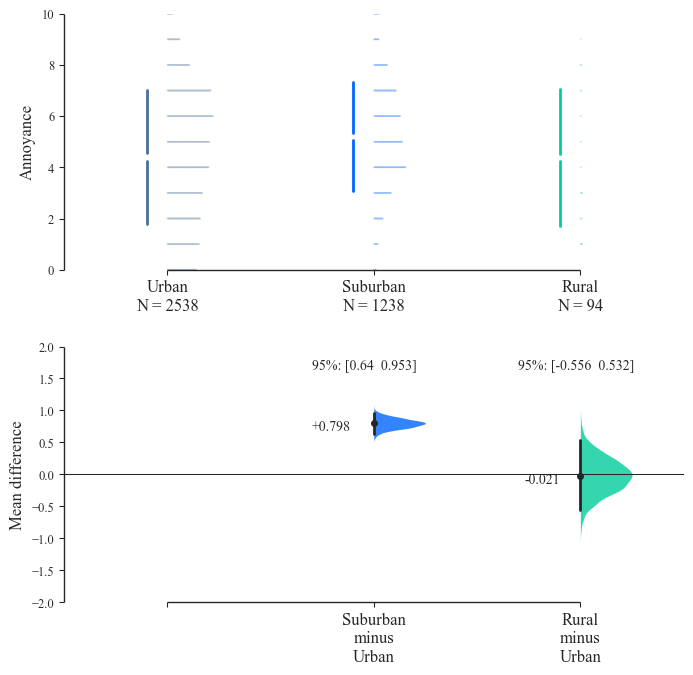

In [103]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                   raw_marker_size=0.001,
                                   swarmplot_kwargs={'alpha': 0.3},
                                   contrast_show_deltas=False,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette={'Suburban': mycolours[0],
                                                   'Rural': mycolours[1],
                                                   'Urban': mycolours[3]},
                                   swarm_desat=1,
                                   halfviolin_desat=1,
                                   bar_desat=1,
                                   es_marker_size=4,
                                   contrast_ylim=(-2, 2),
                                   ax=ax,
                                   )

diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-3.9, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtsABAORDabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtsABAORDabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [104]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control      test  control_N  test_N effect_size is_paired  difference  ci  \
0   Urban  Suburban       2538    1238   Cohen's d      None    0.321960  95   
1   Urban     Rural       2538      94   Cohen's d      None   -0.008085  95   

    bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0  0.257970  0.384492            0.000200  5.121281e-23        -9.962372   
1 -0.212187  0.202582            0.933813  9.397852e-01         0.075730   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0       2.599062e-20             -9.287360         3.998285e-17   
1       9.386525e-01              0.076971         8.717717e-01   

   statistic_mann_whitney  
0               1308218.0  
1                120447.5

### Area soundscape character

In [55]:
# select subset of data for analysis and sort
data = dataBySubjTest
data = data[data['UASLAeq'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'Area_soundscape', 'Annoyance']]


In [56]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=['Monotonous', 'Calm', 'Chaotic', 'Vibrant'],
                         x='Area_soundscape', y='Annoyance', resamples=5000, random_seed=21064694)


C:\Users\m_lot\AppData\Local\Temp\ipykernel_35620\3578263648.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(outFigPath, "svg", "PtsABScapeDabestBase.svg"),
C:\Users\m_lot\AppData\Local\Temp\ipykernel_35620\3578263648.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(outFigPath, "pdf", "PtsABScapeDabestBase.pdf"),
C:\Users\m_lot\AppData\Local\Temp\ipykernel_35620\3578263648.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(outFigPath, "pdf", "PtsABScapeDabestBase.pdf"),


control     test  control_N  test_N      effect_size is_paired  \
0  Monotonous     Calm        376    1880  mean difference      None   
1  Monotonous  Chaotic        376     376  mean difference      None   
2  Monotonous  Vibrant        376    1238  mean difference      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0    0.154787  95 -0.112234  0.421277            0.247750      0.256800   
1    0.430851  95  0.050532  0.784574            0.018396      0.020444   
2    0.688692  95  0.412268  0.972760            0.000200      0.000003   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0        -1.135209           0.252224             -1.145258   
1        -2.323075           0.020442             -2.323075   
2        -4.732668           0.000007             -4.520023   

   pvalue_mann_whitney  statistic_mann_whitney  
0         2.000882e-01                338777.0  
1         2.244985e-03                 61651.0  
2         9.778189e-07                194234.0

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


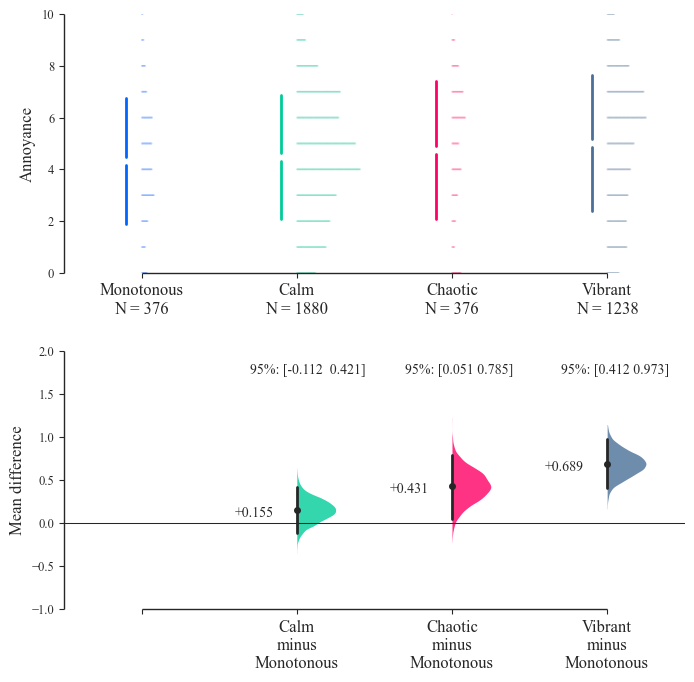

In [57]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                   raw_marker_size=0.002,
                                   swarmplot_kwargs={'alpha': 0.3},
                                   contrast_show_deltas=False,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette={'Monotonous': mycolours[0],
                                                   'Calm': mycolours[1],
                                                   'Chaotic': mycolours[2],
                                                   'Vibrant': mycolours[3]},
                                   swarm_desat=1,
                                   halfviolin_desat=1,
                                   bar_desat=1,
                                   es_marker_size=4,
                                   contrast_ylim=(-1, 2),
                                   ax=ax,
                                   )

diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-3.9, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtsABScapeDabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtsABScapeDabestBase.pdf"),
                format='pdf', bbox_inches='tight')
# out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [58]:
# calculate and display Cohen's d
# outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control     test  control_N  test_N effect_size is_paired  difference  \
0  Monotonous     Calm        376    1880   Cohen's d      None    0.064699   
1  Monotonous  Chaotic        376     376   Cohen's d      None    0.169428   
2  Monotonous  Vibrant        376    1238   Cohen's d      None    0.266157   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0  95 -0.046910  0.176512            0.247750      0.256800        -1.135209   
1  95  0.020655  0.313304            0.018596      0.020444        -2.323075   
2  95  0.158168  0.378919            0.000200      0.000003        -4.732668   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0           0.252224             -1.145258         2.000882e-01   
1           0.020442             -2.323075         2.244985e-03   
2           0.000007             -4.520023         9.778189e-07   

   statistic_mann_whitney  
0                338777.0  
1                 61651.0  
2                194234.0

### Nationality region

In [7]:
# select subset of data for analysis and sort
data = dataBySubjTest
data = data[data['UASLAeq'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'UASLAeq', 'NationGeo', 'Annoyance']]


In [8]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=['UK', 'Africa', 'EastAsia', 'MidEast', 'SouthAsia', 'Europe', 'SouthAmerica', 'Australasia'],
                         x='NationGeo', y='Annoyance', resamples=5000, random_seed=65494894)


control          test  control_N  test_N      effect_size is_paired  \
0      UK        Africa       1708     752  mean difference      None   
1      UK      EastAsia       1708     376  mean difference      None   
2      UK       MidEast       1708     282  mean difference      None   
3      UK     SouthAsia       1708     188  mean difference      None   
4      UK        Europe       1708      94  mean difference      None   
5      UK  SouthAmerica       1708      94  mean difference      None   
6      UK   Australasia       1708      94  mean difference      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0   -1.216223  95 -1.433673 -0.997593            0.000200  4.970285e-26   
1    0.438033  95  0.167236  0.706519            0.002000  1.663058e-03   
2    1.313033  95  1.042790  1.574526            0.000200  3.884421e-19   
3   -0.910372  95 -1.186631 -0.631970            0.000200  8.467463e-10   
4    0.621543  95  0.245117  0.989972            0.014597  1.329701e-03   
5    2.919416  95  2.427027  3.339877            0.000200  5.121429e-23   
6    1.610905  95  1.237319  1.965581            0.000200  1.886095e-14   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0        10.776461       6.295599e-28             11.091125   
1        -3.160110       1.674955e-03             -3.146637   
2        -9.395614       3.732686e-17             -8.497746   
3         6.361590       7.759408e-07              4.957950   
4        -3.290645       1.523101e-02             -2.429163   
5       -12.679337       8.725824e-29            -11.328408   
6        -8.762659       3.714025e-10             -6.300797   

   pvalue_mann_whitney  statistic_mann_whitney  
0         9.463814e-26                811401.5  
1         3.369082e-03                290350.0  
2         7.427490e-19                162126.5  
3         6.296411e-08                198811.5  
4         2.134054e-02                 69053.0  
5         8.778196e-26                 29055.0  
6         5.720153e-11                 48333.0

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


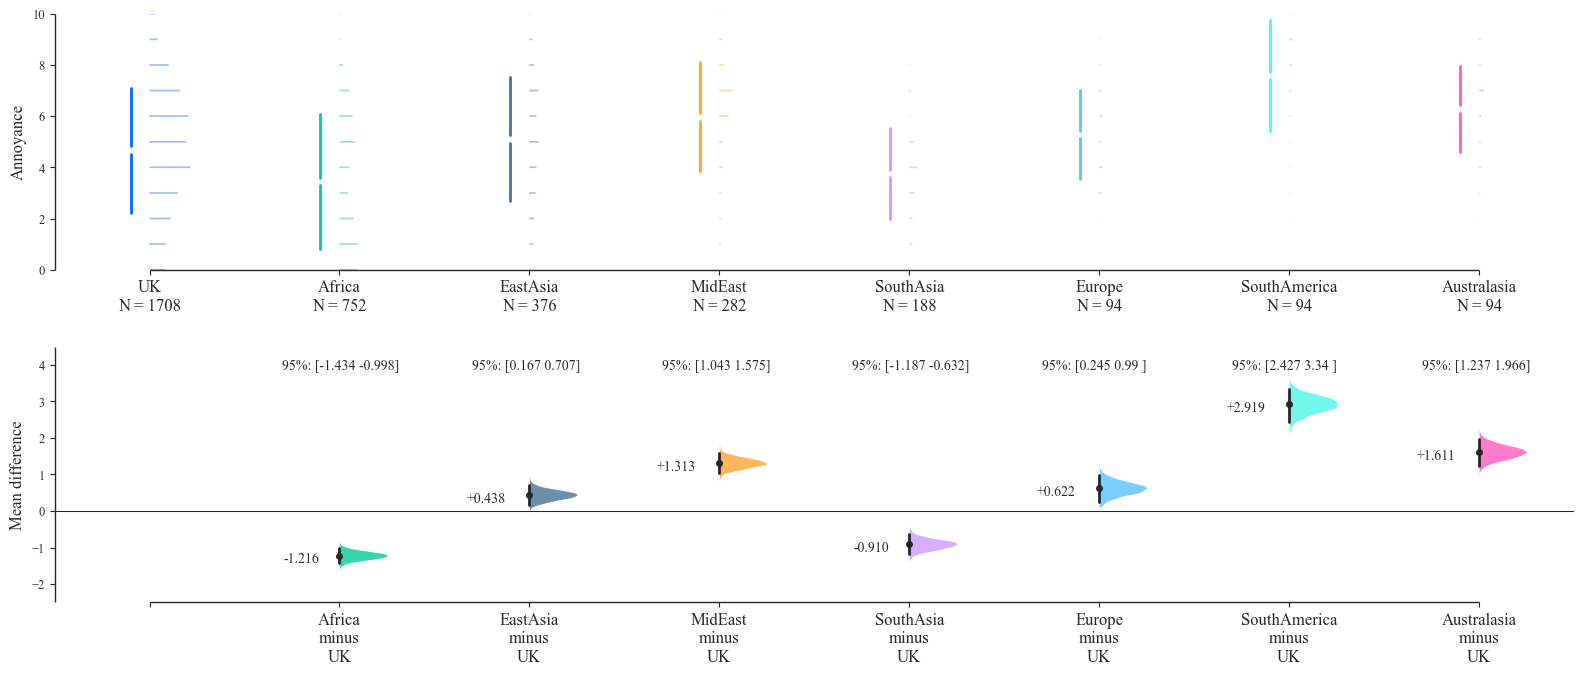

In [13]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(16, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                   raw_marker_size=0.001,
                                   swarmplot_kwargs={'alpha': 0.3},
                                   contrast_show_deltas=False,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette={'UK': mycolours[0],
                                                   'Africa': mycolours[1],
                                                   'EastAsia': mycolours[3],
                                                   'MidEast': mycolours[4],
                                                   'SouthAsia': mycolours[5],
                                                   'Europe': mycolours[6],
                                                   'SouthAmerica': mycolours[7],
                                                   'Australasia': mycolours[8]},
                                   swarm_desat=1,
                                   halfviolin_desat=1,
                                   bar_desat=1,
                                   es_marker_size=4,
                                   contrast_ylim=(-2.5, 4.5),
                                   ax=ax,
                                   )

diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-3.9, s="95%: " + str(diffrow[1:]), fontsize=10)

dataMD;
dataloadBL.mean_diff.statistical_tests


In [14]:
# calculate and display Cohen's d
dataloadBL.cohens_d.statistical_tests


control          test  control_N  test_N effect_size is_paired  difference  \
0      UK        Africa       1708     752   Cohen's d      None   -0.485389   
1      UK      EastAsia       1708     376   Cohen's d      None    0.179249   
2      UK       MidEast       1708     282   Cohen's d      None    0.546213   
3      UK     SouthAsia       1708     188   Cohen's d      None   -0.380977   
4      UK        Europe       1708      94   Cohen's d      None    0.257351   
5      UK  SouthAmerica       1708      94   Cohen's d      None    1.200158   
6      UK   Australasia       1708      94   Cohen's d      None    0.667521   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0  95 -0.575995 -0.397099            0.000200  4.970285e-26        10.776461   
1  95  0.067193  0.288327            0.002000  1.663058e-03        -3.160110   
2  95  0.431696  0.659420            0.000200  3.884421e-19        -9.395614   
3  95 -0.498913 -0.265947            0.000200  8.467463e-10         6.361590   
4  95  0.102074  0.411162            0.014597  1.329701e-03        -3.290645   
5  95  0.988500  1.382107            0.000200  5.121429e-23       -12.679337   
6  95  0.510903  0.818811            0.000200  1.886095e-14        -8.762659   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0       6.295599e-28             11.091125         9.463814e-26   
1       1.674955e-03             -3.146637         3.369082e-03   
2       3.732686e-17             -8.497746         7.427490e-19   
3       7.759408e-07              4.957950         6.296411e-08   
4       1.523101e-02             -2.429163         2.134054e-02   
5       8.725824e-29            -11.328408         8.778196e-26   
6       3.714025e-10             -6.300797         5.720153e-11   

   statistic_mann_whitney  
0                811401.5  
1                290350.0  
2                162126.5  
3                198811.5  
4                 69053.0  
5                 29055.0  
6                 48333.0

In [15]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=['UK', 'Africa'],
                         x='NationGeo', y='Annoyance', resamples=5000, random_seed=65494894)


control    test  control_N  test_N      effect_size is_paired  difference  \
0      UK  Africa       1708     752  mean difference      None   -1.216223   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0  95 -1.433673 -0.997593              0.0002  4.970285e-26        10.776461   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0       6.295599e-28             11.091125         9.463814e-26   

   statistic_mann_whitney  
0                811401.5

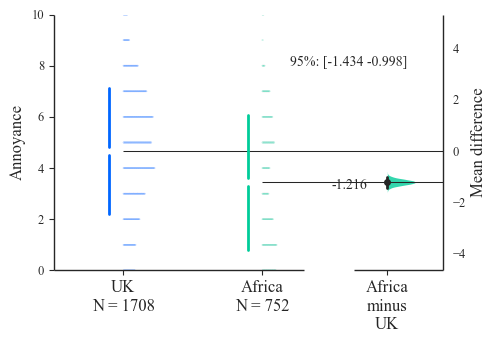

In [19]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(5, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                   raw_marker_size=0.001,
                                   swarmplot_kwargs={'alpha': 0.3},
                                   contrast_show_deltas=False,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette={'UK': mycolours[0],
                                                   'Africa': mycolours[1]},
                                   swarm_desat=1,
                                   halfviolin_desat=1,
                                   bar_desat=1,
                                   es_marker_size=4,
                                   contrast_ylim=(-2, 0),
                                   ax=ax,
                                   )

diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=1.4 + ii, y=8, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtsABNationDabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtsABNationDabestBase.pdf"),
                format='pdf', bbox_inches='tight')
out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [20]:
# calculate and display Cohen's d
outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control    test  control_N  test_N effect_size is_paired  difference  ci  \
0      UK  Africa       1708     752   Cohen's d      None   -0.485389  95   

    bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0 -0.575995 -0.397099              0.0002  4.970285e-26        10.776461   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0       6.295599e-28             11.091125         9.463814e-26   

   statistic_mann_whitney  
0                811401.5

Combining all non-UK regions into one 'other' group

In [33]:
# create new subset of data for analysis and sort
data = dataBySubjTest.copy()
data.loc[data['NationGeo'] != "UK", 'NationGeo'] = "Other"
data = data[data['UASLAeq'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'UASLAeq', 'NationGeo', 'Annoyance']]


In [34]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=['UK', 'Other'],
                         x='NationGeo', y='Annoyance', resamples=5000, random_seed=5954984962)


control   test  control_N  test_N      effect_size is_paired  difference  \
0      UK  Other       1708    2162  mean difference      None   -0.011667   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0  95 -0.169244  0.145606            0.876225      0.885332         0.144223   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0           0.885952              0.143438             0.972592   

   statistic_mann_whitney  
0               1845169.5

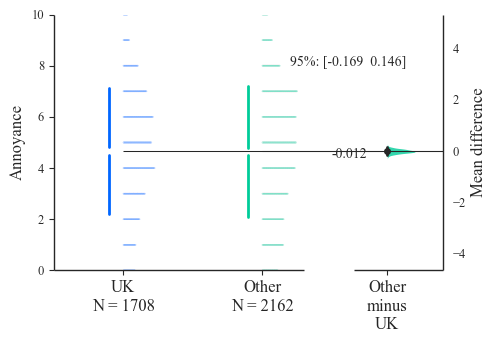

In [35]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(5, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                   raw_marker_size=0.001,
                                   swarmplot_kwargs={'alpha': 0.3},
                                   contrast_show_deltas=False,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette={'UK': mycolours[0],
                                                   'Other': mycolours[1]},
                                   swarm_desat=1,
                                   halfviolin_desat=1,
                                   bar_desat=1,
                                   es_marker_size=4,
                                   contrast_ylim=(-2, 0),
                                   ax=ax,
                                   )

diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=1.4 + ii, y=8, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtsABNation2DabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtsABNation2DabestBase.pdf"),
                format='pdf', bbox_inches='tight')
# out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [38]:
# calculate and display Cohen's d
#outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control   test  control_N  test_N effect_size is_paired  difference  ci  \
0      UK  Other       1708    2162   Cohen's d      None   -0.004644  95   

    bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0 -0.067625  0.058298            0.876225      0.885332         0.144223   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0           0.885952              0.143438             0.972592   

   statistic_mann_whitney  
0               1845169.5

Combining all non-UK regions except Africa into one 'other' group

In [49]:
# create new subset of data for analysis and sort
data = dataBySubjTest.copy()
data.loc[(data['NationGeo'] != "UK") & (data['NationGeo'] != "Africa"), 'NationGeo'] = "Other"
data = data[data['UASLAeq'] != "No UAS"]
data = data.loc[:, ['ID#', 'StimFile', 'UASLAeq', 'NationGeo', 'Annoyance']]


In [53]:
# assign data for processing
dataloadBL = dabest.load(data=data, idx=['UK', 'Africa', 'Other'],
                         x='NationGeo', y='Annoyance', resamples=5000, random_seed=454515665)


C:\Users\m_lot\AppData\Local\Temp\ipykernel_35620\3034600420.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(outFigPath, "svg", "PtsABNation3DabestBase.svg"),
C:\Users\m_lot\AppData\Local\Temp\ipykernel_35620\3034600420.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(outFigPath, "pdf", "PtsABNation3DabestBase.pdf"),
C:\Users\m_lot\AppData\Local\Temp\ipykernel_35620\3034600420.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(outFigPath, "pdf", "PtsABNation3DabestBase.pdf"),


control    test  control_N  test_N      effect_size is_paired  difference  \
0      UK  Africa       1708     752  mean difference      None   -1.216223   
1      UK   Other       1708    1410  mean difference      None    0.630763   

   ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0  95 -1.433162 -0.996531              0.0002  4.970285e-26        10.776461   
1  95  0.461571  0.792151              0.0002  1.287643e-13        -7.441254   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0       6.295599e-28             11.091125         9.463814e-26   
1       1.866158e-13             -7.390725         6.861872e-12   

   statistic_mann_whitney  
0                811401.5  
1               1033768.0

C:\Users\m_lot\OneDrive - University of Salford\Code\DABEST-python_devMJBL\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


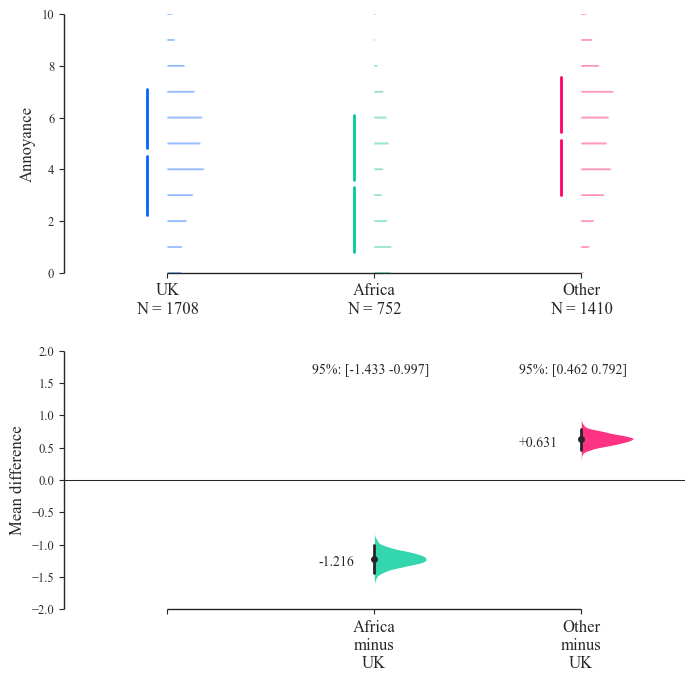

In [54]:
# calculate baseline paired effect sizes and plot
fig, ax = plt.subplots(figsize=(7, 3.5))
dataMD = dataloadBL.mean_diff.plot(swarm_ylim=(0, 10),
                                   raw_marker_size=0.001,
                                   swarmplot_kwargs={'alpha': 0.3},
                                   contrast_show_deltas=False,
                                   contrast_show_es=True, es_sf=3,
                                   custom_palette={'UK': mycolours[0],
                                                   'Africa': mycolours[1],
                                                   'Other': mycolours[2]},
                                   swarm_desat=1,
                                   halfviolin_desat=1,
                                   bar_desat=1,
                                   es_marker_size=4,
                                   contrast_ylim=(-2, 2),
                                   ax=ax,
                                   )

diffs = np.round(dataloadBL.mean_diff.statistical_tests[['difference', 'bca_low', 'bca_high']].values, 3)
# label results
for ii, diffrow in enumerate(diffs):
    #ax.text(x=0.8 + ii, y=-10.9, s=" " + str(diffrow[0]), fontsize=10)
    ax.text(x=0.7 + ii, y=-3.9, s="95%: " + str(diffrow[1:]), fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtsABNation3DabestBase.svg"),
                format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtsABNation3DabestBase.pdf"),
                format='pdf', bbox_inches='tight')
# out = pd.concat([out, dataloadBL.mean_diff.statistical_tests])

dataMD;
dataloadBL.mean_diff.statistical_tests


In [38]:
# calculate and display Cohen's d
#outd = pd.concat([outd, dataloadBL.cohens_d.statistical_tests])
dataloadBL.cohens_d.statistical_tests


control   test  control_N  test_N effect_size is_paired  difference  ci  \
0      UK  Other       1708    2162   Cohen's d      None   -0.004644  95   

    bca_low  bca_high  pvalue_permutation  pvalue_welch  statistic_welch  \
0 -0.067625  0.058298            0.876225      0.885332         0.144223   

   pvalue_students_t  statistic_students_t  pvalue_mann_whitney  \
0           0.885952              0.143438             0.972592   

   statistic_mann_whitney  
0               1845169.5

## Save output data to file

In [105]:
if savedata:
    out.to_csv(os.path.join(outDataPath, "dabest_mean_diff.csv"))
    outd.to_csv(os.path.join(outDataPath, "dabest_cohens_d.csv"))

# Comparison with DroneNoise data

In [106]:
dataDNoiseWide = pd.read_csv(r"C:\Users\m_lot\OneDrive - University of Salford\REFMAP General\03 Experiment\Experiment 1\Analysis\Comparison_data\DroneNoise2022AnnoyWide.csv")

dataDNoiseLong = dataDNoiseWide.melt(id_vars='ID', var_name='StimFile', value_name='Annoyance')
dataDNoiseLong.head()

ID                                     StimFile  Annoyance
0   1  GD28X_Event-210_mic2_Fast_FO_Closed CAL.wav        0.9
1   2  GD28X_Event-210_mic2_Fast_FO_Closed CAL.wav        2.0
2   3  GD28X_Event-210_mic2_Fast_FO_Closed CAL.wav        0.7
3   4  GD28X_Event-210_mic2_Fast_FO_Closed CAL.wav        0.6
4   6  GD28X_Event-210_mic2_Fast_FO_Closed CAL.wav        1.5

In [107]:
dataDNoiseLong['UASOperation'] = "Flyby"
dataDNoiseLong.loc[dataDNoiseLong['StimFile'].str.contains("Landing"), 'UASOperation'] = "Landing"
dataDNoiseLong.loc[dataDNoiseLong['StimFile'].str.contains("Takeoff"), 'UASOperation'] = "Takeoff"
dataDNoiseLong.loc[dataDNoiseLong['StimFile'].str.contains("Hover"), 'UASOperation'] = "Hover"
dataDNoiseLong['Location'] = "Outdoors"
dataDNoiseLong.loc[dataDNoiseLong['StimFile'].str.contains("Part_Open"), 'Location'] = "Indoors_PO"
dataDNoiseLong.loc[dataDNoiseLong['StimFile'].str.contains("Closed"), 'Location'] = "Indoors_Cl"
dataDNoiseLong['UASType'] = "Typhoon"
dataDNoiseLong.loc[dataDNoiseLong['StimFile'].str.contains("GD28X"), 'UASType'] = "GD28X"
dataDNoiseLong.loc[dataDNoiseLong['StimFile'].str.contains("M200"), 'UASType'] = "M200"

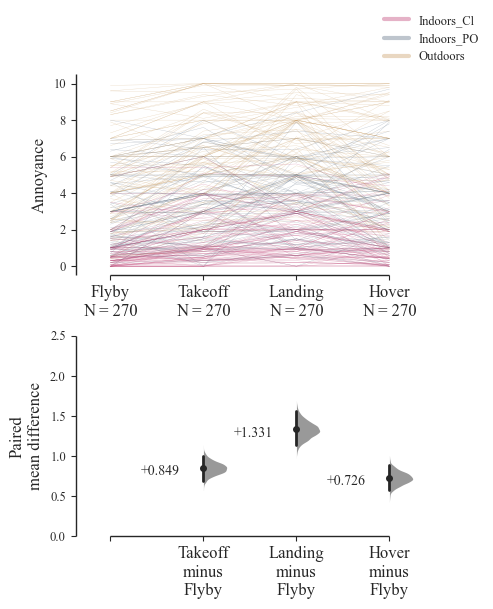

In [108]:
dataDNoiseLong.sort_values(by=['ID', 'Location', 'UASType', 'UASOperation'], inplace=True)
dataDNoiseLong['dummyID'] = np.repeat(np.arange(1, len(dataDNoiseLong['ID'])//len(dataDNoiseLong['UASOperation'].unique()) + 1, dtype=int), len(dataDNoiseLong['UASOperation'].unique()), axis=0)

dataDNoiseloadBL = dabest.load(data=dataDNoiseLong, idx=("Flyby", "Takeoff", "Landing", "Hover"),
                               x='UASOperation', y='Annoyance', paired='baseline',
                               id_col='dummyID', resamples=5000, random_seed=646)

dataDNoiseBL = dataDNoiseloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='Location',
                                               contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.4},
                                               contrast_show_es=True, es_sf=3,
                                               custom_palette=mycolours[2:], es_marker_size=4, contrast_ylim=(0, 2.5),
                                               legend_kwargs={'loc': 'lower center'})


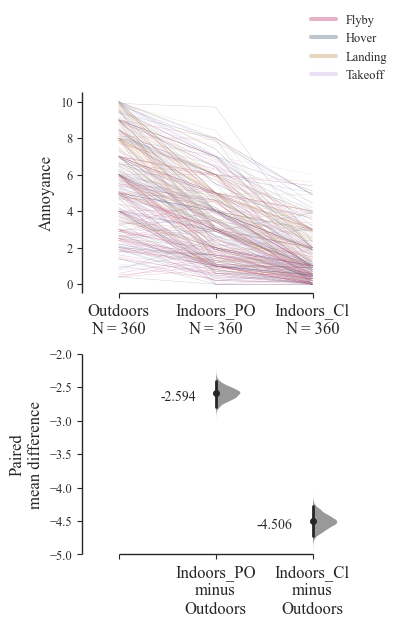

In [109]:
dataDNoiseLong.sort_values(by=['ID', 'UASOperation', 'UASType', 'Location'], inplace=True)
dataDNoiseLong['dummyID'] = np.repeat(np.arange(1, len(dataDNoiseLong['ID'])//len(dataDNoiseLong['Location'].unique()) + 1, dtype=int), len(dataDNoiseLong['Location'].unique()), axis=0)

dataDNoiseloadBL = dabest.load(data=dataDNoiseLong, idx=("Outdoors", "Indoors_PO", "Indoors_Cl"),
                               x='Location', y='Annoyance', paired='baseline',
                               id_col='dummyID', resamples=5000, random_seed=4546)

dataDNoiseBL = dataDNoiseloadBL.mean_diff.plot(swarm_ylim=(-0.5, 10.5), color_col='UASOperation',
                                               contrast_show_deltas=False, slopegraph_kwargs={'linewidth': 0.25, 'alpha': 0.4},
                                               contrast_show_es=True, es_sf=3,
                                               custom_palette=mycolours[2:], es_marker_size=4, contrast_ylim=(-5, -2),
                                               legend_kwargs={'loc': 'lower center'})
